In [181]:

from scipy import stats
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, BaggingClassifier, BaggingRegressor, RandomForestClassifier, RandomForestRegressor, VotingClassifier, VotingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, plot_confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import shap
from statsmodels import robust
import time
import xgboost


In [338]:
data = pd.read_csv('../data/cumulative.csv')
#data = pd.read_csv('../data/cumulative_2022.04.28_05.30.33.csv', header=53)
print(f"Anzahl der KOI: {len(data['koi_disposition'])}")
print(
    f"Anzahl falsch positiver KOI: {len(data.loc[data['koi_disposition'] == 'FALSE POSITIVE'])}")
print(
    f"Anzahl der Kandidaten-KOI: {len(data.loc[data['koi_disposition'] == 'CANDIDATE'])}")
print(
    f"Anzahl der bestätigten KOI: {len(data.loc[data['koi_disposition'] == 'CONFIRMED'])}")
print(
    f"Basis-Rate: {len(data.loc[data['koi_disposition'] == 0])/len(data['koi_disposition'])}")
data.head()

# Aber in Excel-Datei von Kaggle sind 2248 Kandidaten, 2294 bestätigte und 5023 falsch positive.
# Ich habe jedoch die Daten vom NASA Exoplanet Archive genommen. https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative



Anzahl der KOI: 9564
Anzahl falsch positiver KOI: 5023
Anzahl der Kandidaten-KOI: 2248
Anzahl der bestätigten KOI: 2293
Basis-Rate: 0.0


,rowid,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3,10811496,K00753.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [339]:
# Pop the columns:
# Spalten mit "id" oder "name" im Namen enthalten nur Bezeichnungen. Die beiden "koi_teq_err"-Spalten sind leer.
to_pop = ["rowid", "kepid", "kepoi_name", "kepler_name", "koi_teq_err1",
          "koi_teq_err2", "koi_tce_delivname"]

for col in to_pop:
    data.pop(col)

# Numerische Werte:
koi_disposition_dict = {'FALSE POSITIVE': 0, 'CANDIDATE': 1, 'CONFIRMED': 2}
data["koi_disposition"] = data["koi_disposition"].replace(
    koi_disposition_dict)

koi_pdisposition_dict = {'FALSE POSITIVE': 0, 'CANDIDATE': 1}
data["koi_pdisposition"] = data["koi_pdisposition"].replace(
    koi_pdisposition_dict)
data.head()



,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,2,1,1.000,0,0,0,0,9.488036,2.775000e-05,-2.775000e-05,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2,1,0.969,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,0,0,0.000,0,1,0,0,19.899140,1.494000e-05,-1.494000e-05,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,0,0,0.000,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,2,1,1.000,0,0,0,0,2.525592,3.761000e-06,-3.761000e-06,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


In [340]:
knn_imputer = KNNImputer()

for column in data:

    data[column] = knn_imputer.fit_transform(
        data[column].to_numpy().reshape(-1, 1))

In [89]:
corr_pdisp = []
for col_index in range(0,43):
    corr_pdisp.append(stats.pearsonr(data[:, 1], data[:, col_index]))

    if abs(corr_pdisp[col_index][0]) >= 0.1:
        print(
            f"Korrelation von koi_pdisposition mit {col_names[col_index]}: {corr_pdisp[col_index]}")
    #print(f"Korrelation von koi_pdisposition mit {column}:  {stats.pearsonr(data['koi_pdisposition'],data[column])}")

#zip(col_index, (correlation[i][0] for i in range(0,43)))

InvalidIndexError: (slice(None, None, None), 1)

In [ ]:
corr_disp = []
for col_index in range(0, 43):
    corr_disp.append(stats.pearsonr(data[:, 0], data[:, col_index]))

    if abs(corr_disp[col_index][0]) >= 0.1:
        print(
            f"Korrelation von koi_disposition mit {col_names[col_index]}: {corr_disp[col_index]}")
    #print(f"Korrelation von koi_pdisposition mit {column}:  {stats.pearsonr(data['koi_pdisposition'],data[column])}")

#zip(col_index, (correlation[i][0] for i in range(0,43)))


Korrelation von koi_disposition mit koi_disposition: (0.9999999999999959, 0.0)
Korrelation von koi_disposition mit koi_pdisposition: (0.9105929821633059, 0.0)
Korrelation von koi_disposition mit koi_score: (0.8473352157697137, 0.0)
Korrelation von koi_disposition mit koi_fpflag_ss: (-0.48848059950845785, 0.0)
Korrelation von koi_disposition mit koi_fpflag_co: (-0.4478050288288689, 0.0)
Korrelation von koi_disposition mit koi_fpflag_ec: (-0.33337287477622735, 5.842120486641862e-247)
Korrelation von koi_disposition mit koi_period_err1: (-0.1219394547818135, 5.2096808474842046e-33)
Korrelation von koi_disposition mit koi_period_err2: (0.1219394547818135, 5.2096808474842046e-33)
Korrelation von koi_disposition mit koi_impact_err1: (-0.12373969027521263, 5.999669667966453e-34)
Korrelation von koi_disposition mit koi_duration: (-0.15395502528186986, 8.232728893409177e-52)
Korrelation von koi_disposition mit koi_duration_err1: (-0.15120818932854865, 5.072931185526416e-50)
Korrelation von koi_

In [ ]:
corr_score = []
for col_index in range(0, 43):
    corr_score.append(stats.pearsonr(data[:, 2], data[:, col_index]))

    if abs(corr_score[col_index][0]) >= 0.1:
        print(
            f"Korrelation von koi_score mit {col_names[col_index]}: {corr_score[col_index]}")
    #print(f"Korrelation von koi_pdisposition mit {column}:  {stats.pearsonr(data['koi_pdisposition'],data[column])}")

#zip(col_index, (correlation[i][0] for i in range(0,43)))


Korrelation von koi_score mit koi_disposition: (0.8473352157697137, 0.0)
Korrelation von koi_score mit koi_pdisposition: (0.8206417014383628, 0.0)
Korrelation von koi_score mit koi_score: (1.0, 0.0)
Korrelation von koi_score mit koi_fpflag_ss: (-0.4880688842452924, 0.0)
Korrelation von koi_score mit koi_fpflag_co: (-0.45277954331075654, 0.0)
Korrelation von koi_score mit koi_fpflag_ec: (-0.35721838500080627, 8.093315745682355e-286)
Korrelation von koi_score mit koi_period_err1: (-0.12887642505914254, 1.0535478964422537e-36)
Korrelation von koi_score mit koi_period_err2: (0.12887642505914254, 1.0535478964422537e-36)
Korrelation von koi_score mit koi_impact_err1: (-0.10273015822636596, 7.353513339827759e-24)
Korrelation von koi_score mit koi_duration: (-0.1753663242430547, 6.437587294402494e-67)
Korrelation von koi_score mit koi_duration_err1: (-0.14411636670147598, 1.4846630464086596e-45)
Korrelation von koi_score mit koi_duration_err2: (0.14411636670147598, 1.4846630464086596e-45)
Korr

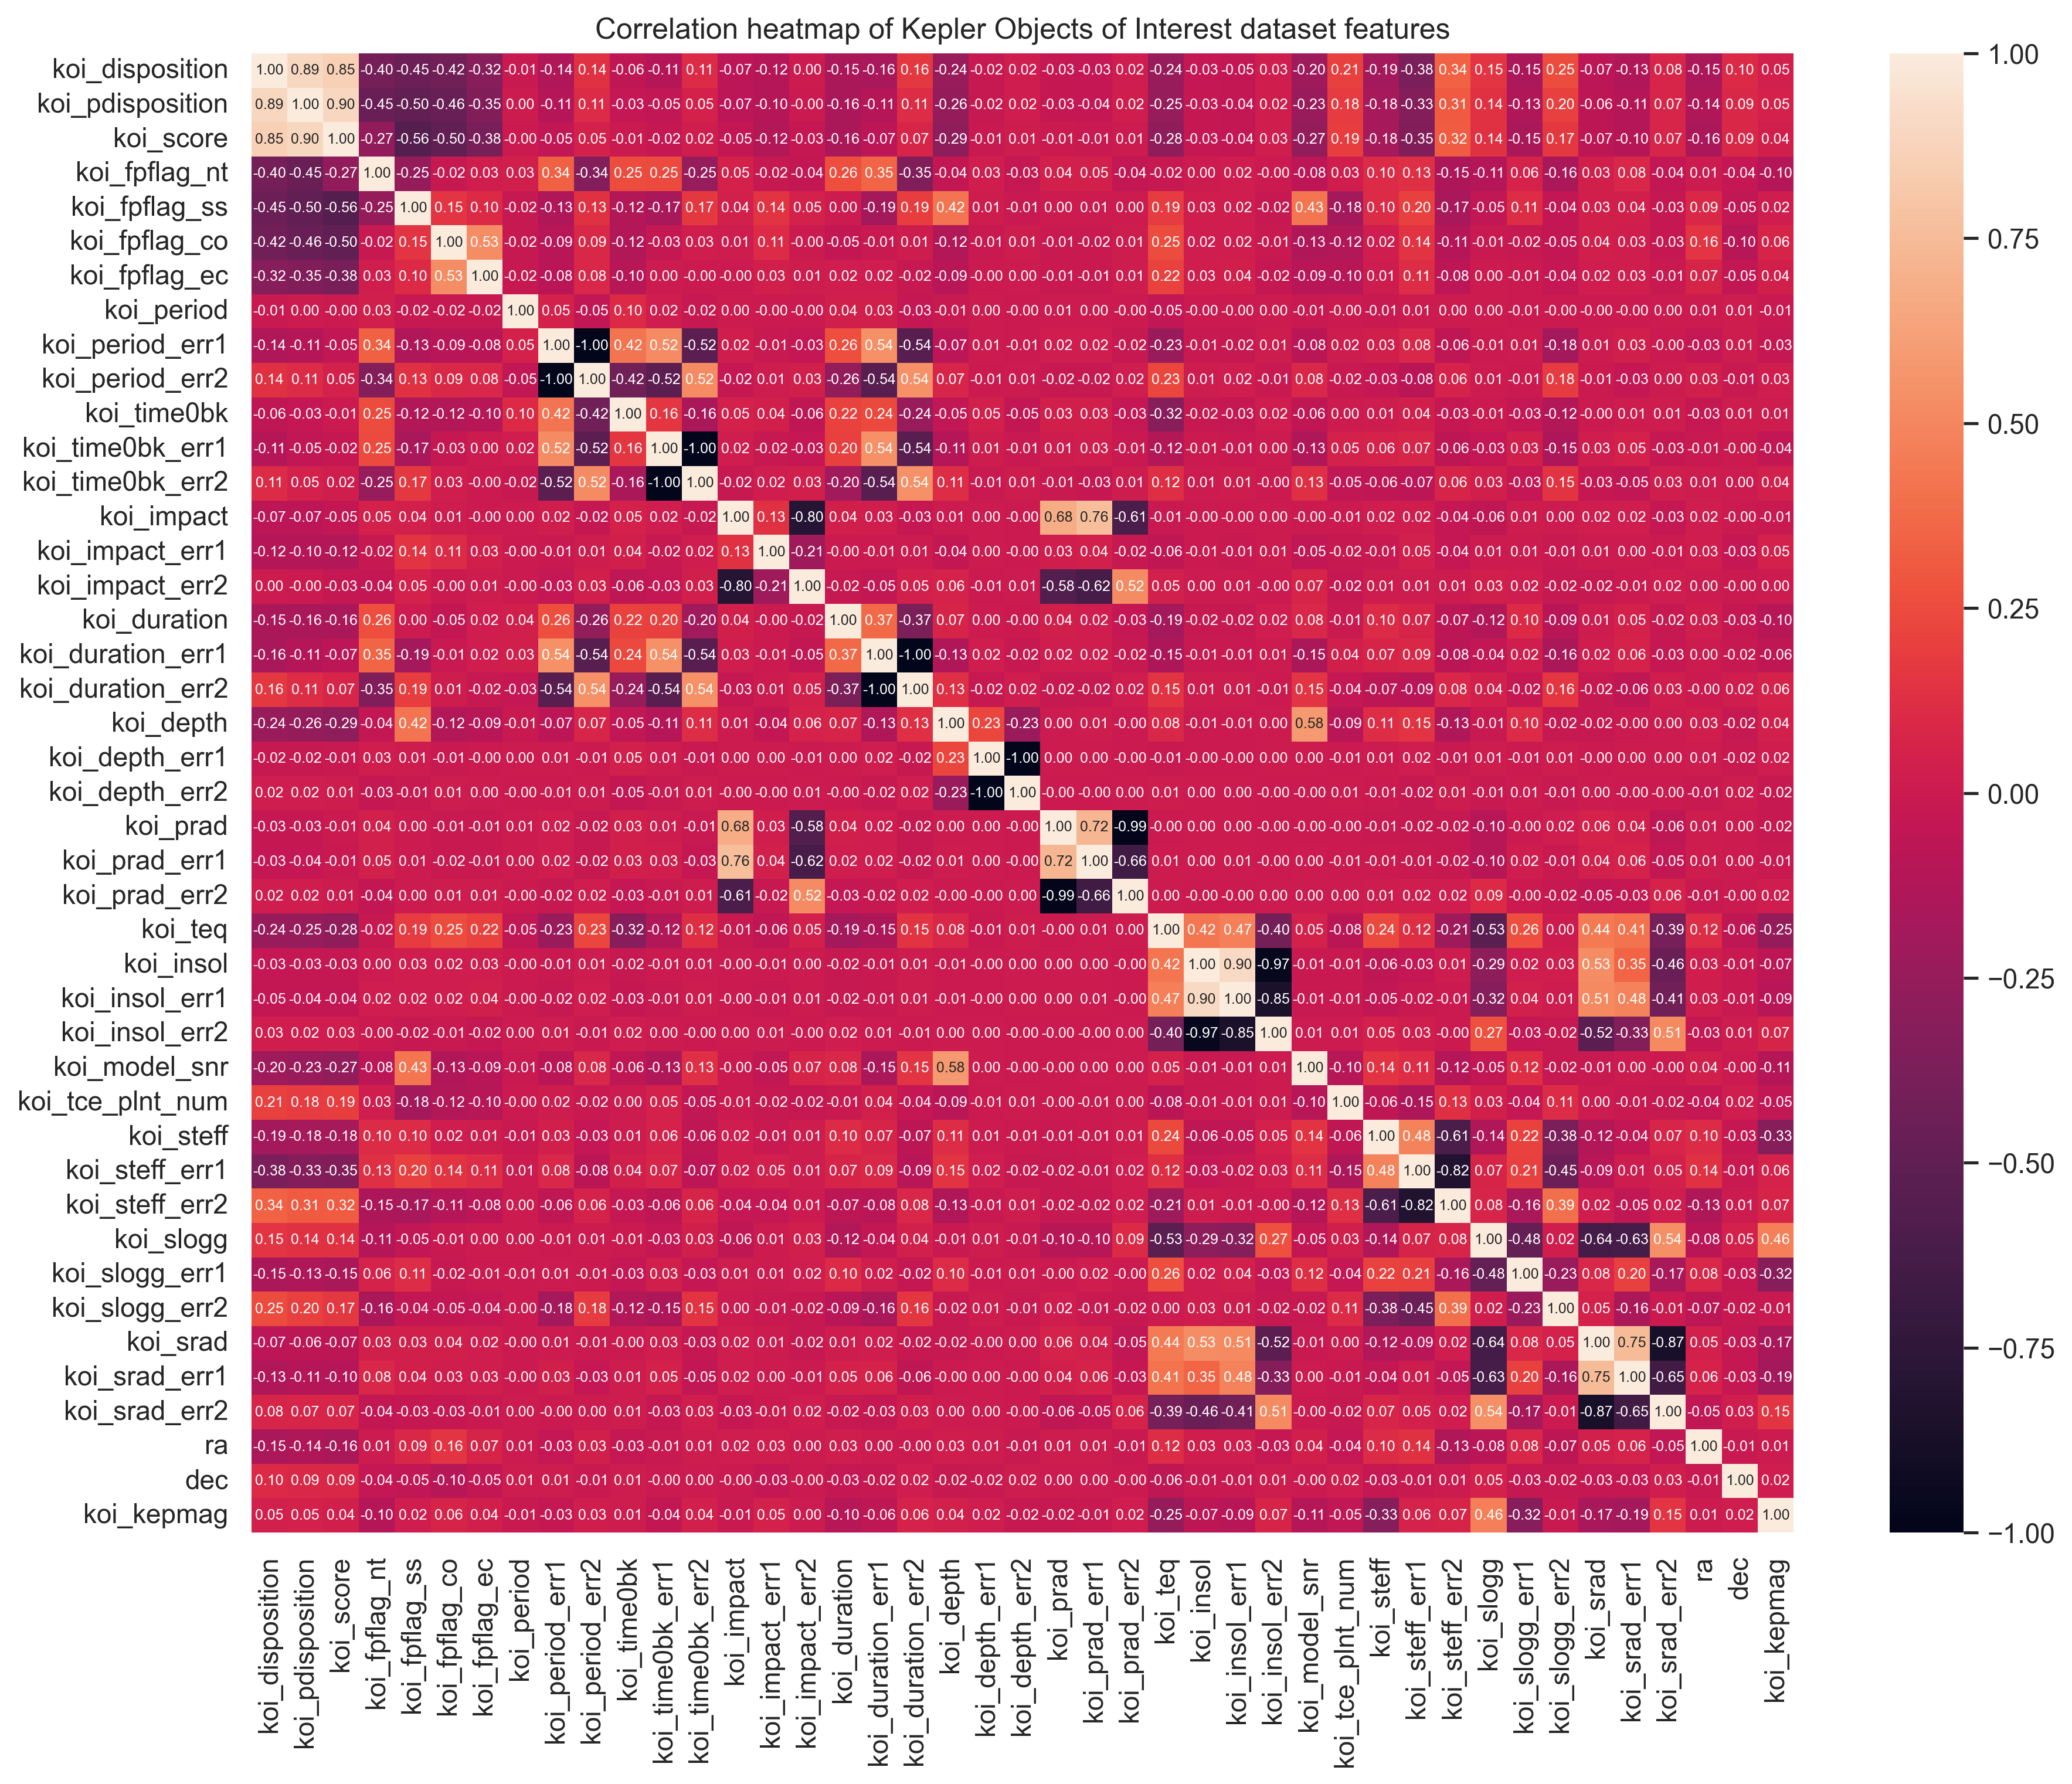

In [353]:
fig = plt.figure(figsize=(14.14, 11.14), dpi=300)
plt.title("Correlation heatmap of Kepler Objects of Interest dataset features")#,fontsize=25)
sns.set(font_scale=1)
sns.heatmap(data.corr(), annot=True, annot_kws={"fontsize":6}, fmt='.2f')
# heat_map = sns.heatmap(data.corr(), annot=True, fmt='.2f')
#heat_map.ax_heatmap.set_xticklabels(heat_map.ax_heatmap.get_xmajorticklabels(), fontsize=16)
#sns.heatmap(data.corr(), annot=True, fmt='.2f')
#plt.legend(fontsize = 20)
#heat_map.set_xticklabels(heat_map.get_xmajorticklabels(), fontsize=20)
#heat_map.set_yticklabels(heat_map.get_ymajorticklabels(), fontsize=20)

plt.savefig('../data/figures/heatmap.png')


In [311]:
data.head()

,rowid,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,1.0,2.0,1.0,1.000,0.0,0.0,0.0,0.0,9.488036,2.775000e-05,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,2.0,2.0,1.0,0.969,0.0,0.0,0.0,0.0,54.418383,2.479000e-04,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,3.0,0.0,0.0,0.000,0.0,1.0,0.0,0.0,19.899140,1.494000e-05,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,4.0,0.0,0.0,0.000,0.0,1.0,0.0,0.0,1.736952,2.630000e-07,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,5.0,2.0,1.0,1.000,0.0,0.0,0.0,0.0,2.525592,3.761000e-06,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


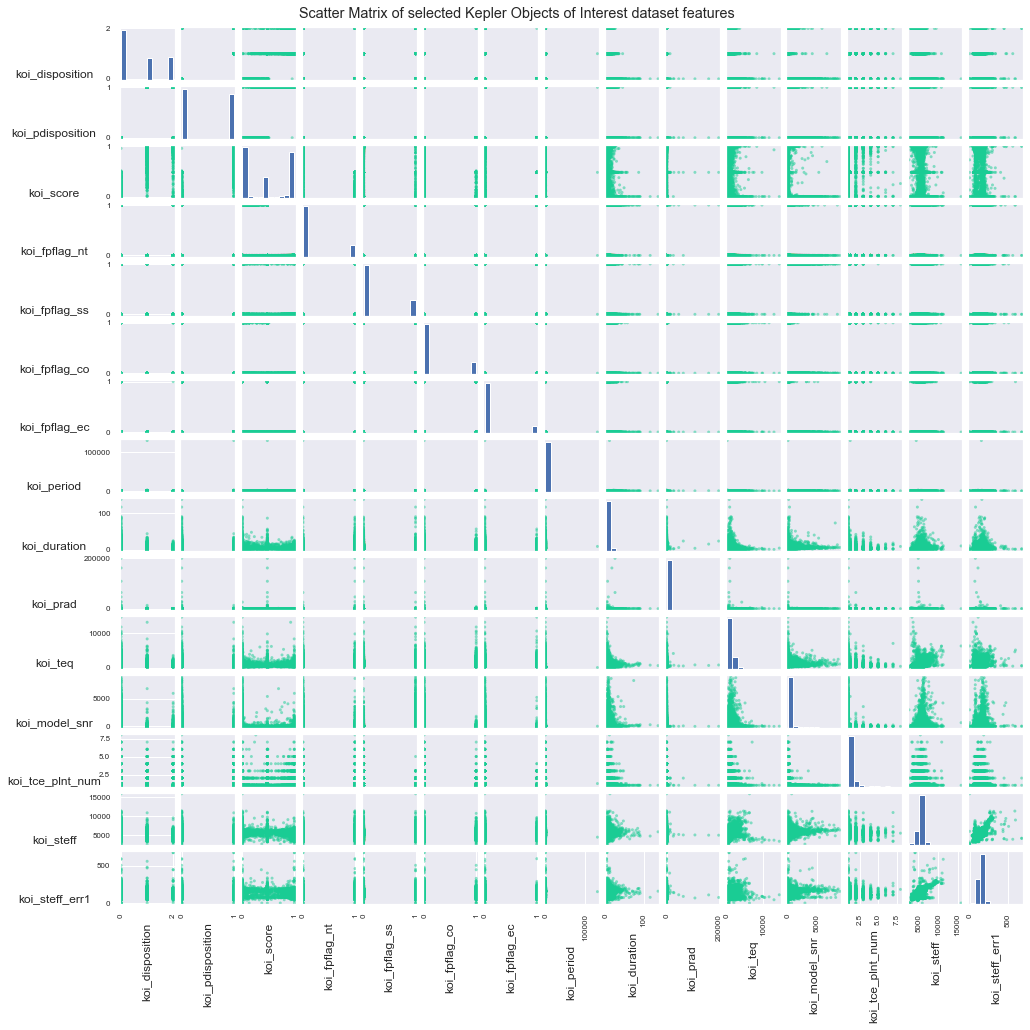

In [333]:
scatter_data = data.copy()
to_pop = ['koi_period_err1', 'koi_period_err2', 'koi_time0bk', 'koi_time0bk_err1',
          'koi_time0bk_err2', 'koi_impact', 'koi_impact_err1', 'koi_impact_err2',
          'koi_duration_err1', 'koi_duration_err2', 'koi_depth', 'koi_depth_err1', 'koi_depth_err2',
           'koi_prad_err1', 'koi_prad_err2', 'koi_insol', 'koi_insol_err1', 'koi_insol_err2',
           'koi_steff_err2', 'koi_slogg', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad',
           'koi_srad_err1', 'koi_srad_err2', 'ra', 'dec', 'koi_kepmag']

          
          
          # 'koi_steff', 'koi_steff_err1', 'koi_steff_err2', 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad_err1', 'koi_srad_err2']

for col in to_pop:
    scatter_data.pop(col)

#scatter_data = scatter_data["koi_disposition"].to_numpy().reshape(-1, 1)

scatter_matrix = pd.plotting.scatter_matrix(
    scatter_data, figsize=(14.14, 14.14), c = "#1ACC94")
# ,fontsize=25)
for ax in scatter_matrix.ravel():
    ax.set_xlabel(ax.get_xlabel(), rotation=90)  # fontsize=20,
    ax.set_ylabel(ax.get_ylabel(), rotation=0)  # , fontsize=20
    ax.yaxis.set_label_coords(-1.2, 0)
plt.suptitle(
    "Scatter Matrix of selected Kepler Objects of Interest dataset features", y=1)
#pd.plotting.scatter_matrix(scatter_data, figsize=(14.14, 14.14), c="#1ACC94")
#plt.xticks(rotation=-180)
#plt.yticks(rotation=180)
plt.tight_layout(pad = 0.2)
plt.savefig('../data/figures/scatter_matrix.png')

#plt.figure(figsize=(9, 9))
#plt.show()

#5 wichtigsten pro modell:  , koi_depth, koi_prad,
#, koi_teq, koi_model_snr, koi_steff_err1, koi_steff_err2, koi_model_snr, dec, ra,


In [341]:
# MinMax nur um den Boxplot darzustellen. Danach müssen Trainings- und Testdaten individuell MinMax-skaliert werden.

scaled_data = data.copy()
minmax = MinMaxScaler()

minmax = MinMaxScaler()
for column in scaled_data:

    scaled_data[column] = minmax.fit_transform(scaled_data[column].to_numpy().reshape(-1, 1))


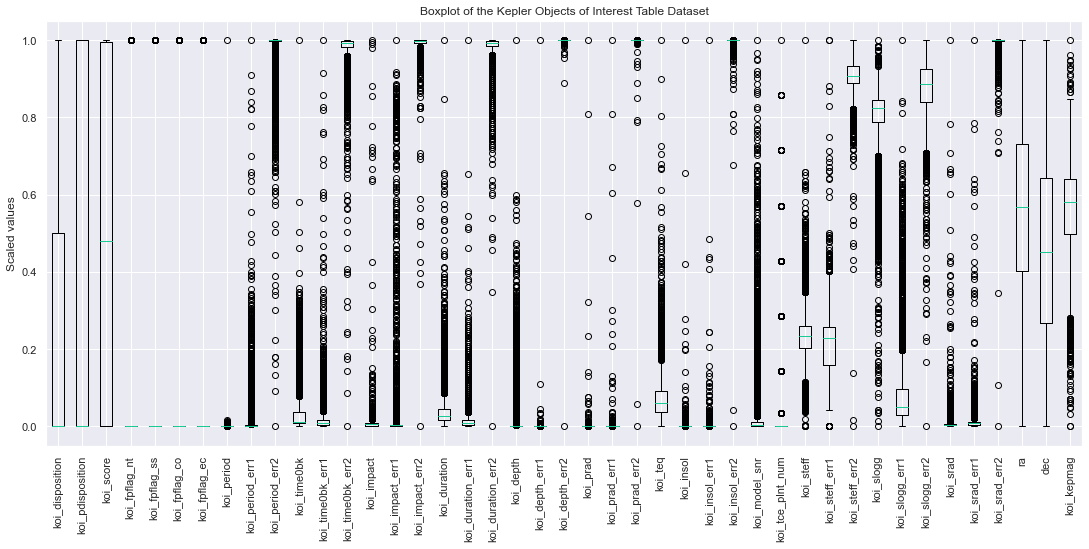

In [348]:
fig = plt.figure(figsize=(15, 7.5))
plt.title("Boxplot of the Kepler Objects of Interest Table Dataset")
plt.boxplot(scaled_data, labels=data.columns, medianprops=dict(color="#1ACC94"))
plt.xticks(rotation=90)
plt.ylabel("Scaled values")
plt.tight_layout(pad=0.2)

plt.savefig('../data/figures/boxplot.png')
plt.show()

In [8]:
# *_err*-Features zu entfernen verringert die Akkuranz
x = data.drop(['koi_disposition', 'koi_pdisposition', 'koi_score', 'koi_fpflag_ss', 'koi_fpflag_co',
               'koi_fpflag_ec', 'koi_fpflag_nt'], axis=1)
y = data["koi_disposition"].to_numpy().reshape(-1, 1)
type(x), type(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)#, random_state=45)

In [174]:
scaled_data


,rowid,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,0.000000,1.0,1.0,1.000,0.0,0.0,0.0,0.0,0.000071,1.608696e-04,...,0.954030,0.831296,0.043478,0.920464,0.003560,0.003173,0.999475,0.552473,0.733837,0.642863
1,0.000105,1.0,1.0,0.969,0.0,0.0,0.0,0.0,0.000417,1.437101e-03,...,0.954030,0.831296,0.043478,0.920464,0.003560,0.003173,0.999475,0.552473,0.733837,0.642863
2,0.000209,0.0,0.0,0.000,0.0,1.0,0.0,0.0,0.000151,8.660870e-05,...,0.900114,0.845778,0.029891,0.854184,0.003303,0.007041,0.999328,0.784346,0.733360,0.649689
3,0.000314,0.0,0.0,0.000,0.0,1.0,0.0,0.0,0.000012,1.524638e-06,...,0.901249,0.849539,0.036005,0.860812,0.002968,0.006074,0.999423,0.259826,0.742947,0.662039
4,0.000418,1.0,1.0,1.000,0.0,0.0,0.0,0.0,0.000018,2.180290e-05,...,0.880250,0.825842,0.047554,0.826015,0.004077,0.010093,0.998855,0.407085,0.739203,0.655289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,0.999582,0.0,0.0,0.000,0.0,0.0,0.0,1.0,0.000064,1.070145e-03,...,0.913734,0.799135,0.156929,0.843413,0.004260,0.009459,0.998037,0.864114,0.659700,0.576206
9560,0.999686,0.0,0.0,0.000,0.0,1.0,1.0,0.0,0.000002,6.724638e-07,...,0.905789,0.842957,0.023777,0.837614,0.003455,0.007162,0.999320,0.792756,0.667345,0.545831
9561,0.999791,0.5,1.0,0.497,0.0,0.0,0.0,0.0,0.000012,1.031884e-04,...,0.875142,0.826970,0.038043,0.814416,0.004012,0.010305,0.999018,0.304401,0.671749,0.597607
9562,0.999895,0.0,0.0,0.021,0.0,0.0,1.0,0.0,0.000003,1.411014e-05,...,0.866061,0.827534,0.038043,0.814416,0.004056,0.010305,0.999018,0.654479,0.672578,0.645777


In [177]:
scaled_data = scaled_data.drop(['koi_pdisposition', 'koi_score', 'koi_fpflag_ss', 'koi_fpflag_co',
                  'koi_fpflag_ec', 'koi_fpflag_nt'], axis=1)


In [9]:
minmax = MinMaxScaler()
for column in x_train:

    if column == 'koi_disposition':
        pass
    else:
        x_train[column] = minmax.fit_transform(x_train[column].to_numpy().reshape(-1, 1))

        x_test[column] = minmax.fit_transform(x_test[column].to_numpy().reshape(-1, 1))

x_train.head()


,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
1148,0.000013,0.000017,0.999983,0.010065,0.001963,0.998037,0.001042,0.004057,0.998230,0.009883,...,0.949221,0.886590,0.030645,0.971002,0.002118,0.000907,0.999644,0.150116,0.449257,0.593019
7748,0.000040,0.000042,0.999958,0.009727,0.001683,0.998317,0.012876,0.078560,0.996510,0.022797,...,0.908252,0.833553,0.062903,0.849213,0.004330,0.007192,0.999018,0.713293,0.228337,0.503235
3334,0.000100,0.000164,0.999836,0.041279,0.002543,0.997457,0.005129,0.004314,0.994943,0.019036,...,0.951529,0.893925,0.052419,0.971002,0.001857,0.001209,0.999490,0.859702,0.468165,0.611790
9322,0.003037,0.128635,0.871365,0.030798,0.058150,0.941850,0.004464,0.000526,0.992768,0.153042,...,0.899596,0.836186,0.064516,0.927092,0.004224,0.003022,0.999124,0.473165,0.561129,0.453391
8958,0.000076,0.013698,0.986302,0.013664,0.017433,0.982567,0.007292,0.022912,0.994394,0.010441,...,0.906368,0.801797,0.097369,0.881391,0.009003,0.010948,0.996197,0.972267,0.523423,0.371276


In [10]:
import warnings
warnings.filterwarnings('ignore')
br_test = len(np.where(y_test == 0)[0])/len(y_test)
br_data = len(data.loc[data['koi_disposition'] == 0]) / len(data['koi_disposition'])
print(f"Basisrate der Testdaten: {br_test:.04}")
print(f"Basisrate des Gesamten Datensatzes: {br_data:.04}")

methods = [("logregr", LogisticRegression()), ("knn", KNeighborsClassifier()), ("bag",
BaggingClassifier()), ("svm", SVC()), ("ada", AdaBoostClassifier()), ("tree",
DecisionTreeClassifier()), ("forest", RandomForestClassifier())]

for method in methods:
    model = method[1].fit(x_train, y_train)
    model_predict = np.round(model.predict(x_test))
    model_accuracy = accuracy_score(model_predict, y_test)
    print(f"Genauigkeit von {method[0]}: {model_accuracy:.04}")


vote_estimators = methods[4:] # Nur ohne logreg, knn und bag kann feature importance von vote bestimmt
                              # werden, da erstere keinen accuracy score haben.
voting_class = VotingClassifier(estimators=vote_estimators, weights=[1, 1, 2])
voting_class.fit(x_train, y_train)
predict = np.round(voting_class.predict(x_test))
vot_accuracy = accuracy_score(predict, y_test)
print(f"Genauigkeit vom Voting Classifier: {vot_accuracy:.04}")



Basisrate der Testdaten: 0.5014
Basisrate des Gesamten Datensatzes: 0.506
Genauigkeit von logregr: 0.6669
Genauigkeit von knn: 0.6108
Genauigkeit von bag: 0.6599
Genauigkeit von svm: 0.6557
Genauigkeit von ada: 0.6268
Genauigkeit von tree: 0.493
Genauigkeit von forest: 0.7345
Genauigkeit vom Voting Classifier: 0.7024


In [ ]:
grid_points_degree = np.arange(1, 4)
#grid_points_interaction_only = (False, True)
#grid_points_include_bias = (False, True)
#grid_points_penalty = ("l1", "l2", "none")  # , "elasticnet"
#grid_points_dual = (False, True)
grid_points_C = np.arange(0.1, 7, 0.1)
#grid_points_fit_intercept = (False, True)
#grid_points_solver = ("liblinear", "saga")  # "newton-cg", "lbfgs", "sag",
# Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.
# Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.
# Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.
#  Unsupported set of arguments: The combination of penalty='l1' and loss='logistic_regression' are
# not supported when dual=True, Parameters: penalty='l1', loss='logistic_regression', dual=True
# Only 'saga' solver supports elasticnet penalty, got solver=liblinear.
# l1_ratio: float, default = None. (f. alle Penalties außer) "elasticnet" braucht 0 <= l1_ratio <= 1
# penalty='none' is not supported for the liblinear solver
max_z = -np.inf
best_point_logreg = (1,  0.1)  # , False, False, "l1", False, "newton-cg"

for degree in grid_points_degree:
    #for interaction_only in grid_points_interaction_only:
        #for include_bias in grid_points_include_bias:
            #for penalty in grid_points_penalty:
                #for dual in grid_points_dual:
    for C in grid_points_C:
        # for fit_intercept in grid_points_fit_intercept:
        # for solver in grid_points_solver:

        poly = PolynomialFeatures(degree=degree) 
        # , interaction_only = interaction_only, include_bias = include_bias
        x_poly = poly.fit_transform(x_train) # .reshape(-1, 1))
        logreg = LogisticRegression(tol=1e-4, C=C, solver="newton-cg", max_iter=100)
        #penalty=penalty,  fit_intercept = fit_intercept, , dual = dual
        logreg_fit = logreg.fit(x_poly, y_train)
        prediction = logreg.predict(poly.transform(x_test)) # .reshape(-1, 1)))
        z = accuracy_score(prediction, y_test)
        print(z, max_z, best_point_logreg, (degree, C))
                # , interaction_only, include_bias, penalty, fit_intercept dual , solver
        if z > max_z:
            max_z = z
            best_point_logreg = (degree,  C)
            # , interaction_only, include_bias, penalty, fit_intercept dual, solver

print(f"Bester Punkt mit z={max_z:.04f} gefunden bei {best_point_logreg}")

#0.7048780487804878 0.7076655052264809 (2, 3.8000000000000025)(2, 6.900000000000006)
#Bester Punkt mit z = 0.7077 gefunden bei(2, 3.8000000000000025)

# Bester Punkt bei 0.6825595984943539 . (2,	False,	False,	'l1',	3	True,	'saga')


0.6076655052264809 -inf (1, 1) (1, 0.1)
0.6320557491289198 0.6076655052264809 (1, 0.1) (1, 0.2)
0.6477351916376307 0.6320557491289198 (1, 0.2) (1, 0.30000000000000004)
0.6550522648083623 0.6477351916376307 (1, 0.30000000000000004) (1, 0.4)
0.6585365853658537 0.6550522648083623 (1, 0.4) (1, 0.5)
0.6616724738675959 0.6585365853658537 (1, 0.5) (1, 0.6)
0.6651567944250871 0.6616724738675959 (1, 0.6) (1, 0.7000000000000001)
0.670383275261324 0.6651567944250871 (1, 0.7000000000000001) (1, 0.8)
0.6735191637630662 0.670383275261324 (1, 0.8) (1, 0.9)
0.6745644599303136 0.6735191637630662 (1, 0.9) (1, 1.0)
0.678397212543554 0.6745644599303136 (1, 1.0) (1, 1.1)
0.6825783972125435 0.678397212543554 (1, 1.1) (1, 1.2000000000000002)
0.6853658536585366 0.6825783972125435 (1, 1.2000000000000002) (1, 1.3000000000000003)
0.6857142857142857 0.6853658536585366 (1, 1.3000000000000003) (1, 1.4000000000000001)
0.6846689895470384 0.6857142857142857 (1, 1.4000000000000001) (1, 1.5000000000000002)
0.68362369337

KeyboardInterrupt: 

In [29]:
method_names = ("k-Nearest-Neighbours-Klassifikator", "Support-Vector-Machine-Klassifikator",
                "Random-Forest-Klassifikator")

In [352]:
grid_points_n_neighbors = np.arange(5, 100)
grid_points_weights = ("uniform", "distance")
#grid_points_algorithm = ("auto", "ball_tree", "kd_tree", "brute") ist egal
#grid_points_p = (1, 2) 1 ist besser.

max_z = -np.inf
best_point_knn = (5, "uniform")

for n_neighbors in grid_points_n_neighbors:
    for weights in grid_points_weights:
        #for algorithm in grid_points_algorithm:
            #for p in grid_points_p:
                knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=1)
                knn_model_fit = knn.fit(x_train, y_train.ravel())
                knn_model_predict = knn.predict(x_test)
                z = accuracy_score(knn_model_predict, y_test)
                print(z, max_z, best_point_knn, (n_neighbors, weights))
                if z > max_z:
                    max_z = z
                    best_point_knn = (n_neighbors, weights)

print("=======================================================================")
print(method_names[0])
print(f"Bester Punkt mit Akkuranz ={max_z: .04f} gefunden bei \n"
      f"n_neighbors = {best_point_knn[0]} \n" 
      f"weights = {best_point_knn[1]}")
# Bester Punkt mit z=0.6833 gefunden bei (13, 'uniform')
#Bester Punkt mit z=0.6805 gefunden bei (7, 'uniform')

# 0.6668989547038328 0.7034843205574913 (29, 'distance') (249, 'distance')
# Bester Punkt mit z = 0.7035 gefunden bei(29, 'distance')

0.6710801393728223 -inf (5, 'uniform') (5, 'uniform')
0.6634146341463415 0.6710801393728223 (5, 'uniform') (5, 'distance')
0.681184668989547 0.6710801393728223 (5, 'uniform') (6, 'uniform')
0.6738675958188153 0.681184668989547 (6, 'uniform') (6, 'distance')
0.6766550522648084 0.681184668989547 (6, 'uniform') (7, 'uniform')
0.6763066202090592 0.681184668989547 (6, 'uniform') (7, 'distance')
0.6766550522648084 0.681184668989547 (6, 'uniform') (8, 'uniform')
0.6797909407665506 0.681184668989547 (6, 'uniform') (8, 'distance')
0.6822299651567945 0.681184668989547 (6, 'uniform') (9, 'uniform')
0.6839721254355401 0.6822299651567945 (9, 'uniform') (9, 'distance')
0.6825783972125435 0.6839721254355401 (9, 'distance') (10, 'uniform')
0.6832752613240418 0.6839721254355401 (9, 'distance') (10, 'distance')
0.6829268292682927 0.6839721254355401 (9, 'distance') (11, 'uniform')
0.6825783972125435 0.6839721254355401 (9, 'distance') (11, 'distance')
0.6818815331010453 0.6839721254355401 (9, 'distance') 

KeyboardInterrupt: 

In [358]:
grid_points_C = np.arange(2, 8, 0.1)
# grid_points_kernel = ("linear", "poly", "rbf", "sigmoid")
grid_points_degree = np.arange(5, 9)
# grid_points_gamma = ("scale", "auto")
max_z = -np.inf
# best_point = (1, "linear", 1, "scale")
best_point_svm = (0.1, 1)

for C in grid_points_C:
    #for kernel in grid_points_kernel:
    for degree in grid_points_degree:
            #for gamma in grid_points_gamma:
        svm = SVC(C=C, kernel="poly", degree=degree, gamma="scale", probability=True)
        svm_model_fit = svm.fit(x_train, y_train.ravel())
        svm_model_predict = svm.predict(x_test)
        z = accuracy_score(svm_model_predict, y_test)
        print(z, max_z, best_point_svm, (C, degree))  # kernel, degree, gamma))
        if z > max_z:
            max_z = z
            best_point_svm = (C, degree) # kernel, degree, gamma)

print("=======================================================================")
print(method_names[1])
print(f"Bester Punkt mit Akkuranz ={max_z: .04f} gefunden bei \n"
      f"C = {best_point_svm[0]} \n"
      f"degree = {best_point_svm[1]}")
# Bester Punkt mit z=0.6787 gefunden bei (7.8, 7)
#0.689198606271777 0.7209059233449477 (2.9000000000000004, 6)(7.9, 7)
#Bester Punkt mit z = 0.7209 gefunden bei(2.9000000000000004, 6)

0.6745644599303136 -inf (0.1, 1) (2.0, 5)
0.6867595818815331 0.6745644599303136 (2.0, 5) (2.0, 6)
0.6843205574912892 0.6867595818815331 (2.0, 6) (2.0, 7)
0.6919860627177701 0.6867595818815331 (2.0, 6) (2.0, 8)
0.675609756097561 0.6919860627177701 (2.0, 8) (2.1, 5)
0.686411149825784 0.6919860627177701 (2.0, 8) (2.1, 6)
0.6850174216027874 0.6919860627177701 (2.0, 8) (2.1, 7)
0.694425087108014 0.6919860627177701 (2.0, 8) (2.1, 8)
0.6749128919860627 0.694425087108014 (2.1, 8) (2.2, 5)
0.6857142857142857 0.694425087108014 (2.1, 8) (2.2, 6)
0.6853658536585366 0.694425087108014 (2.1, 8) (2.2, 7)
0.6958188153310104 0.694425087108014 (2.1, 8) (2.2, 8)
0.6749128919860627 0.6958188153310104 (2.2, 8) (2.3000000000000003, 5)
0.6860627177700348 0.6958188153310104 (2.2, 8) (2.3000000000000003, 6)
0.6857142857142857 0.6958188153310104 (2.2, 8) (2.3000000000000003, 7)
0.6968641114982579 0.6958188153310104 (2.2, 8) (2.3000000000000003, 8)
0.6787456445993031 0.6968641114982579 (2.3000000000000003, 8) (2.

In [366]:
#grid_points_n_estimators = np.arange(1, 502, 50)
#grid_points_max_depth = np.arange(1, 11)
#grid_points_min_samples_split = np.arange(2, 33, 3)
#grid_points_max_features = (None, "auto")
#best_point = (1, 1, 2, None)

# grid_points_n_estimators = np.arange(30, 71, 5)
# grid_points_max_depth = np.arange(7, 10)
# grid_points_min_samples_split = np.arange(2, 30, 3)
# grid_points_max_features = (None, "auto")


grid_points_n_estimators = np.arange(50, 70)
grid_points_max_depth = np.arange(7, 14)
grid_points_min_samples_split = np.arange(2, 14)
#grid_points_max_features =  "auto"
max_z = -np.inf
best_point_rf = (35, 7, 2)
for n_estimators in grid_points_n_estimators:
    for max_depth in grid_points_max_depth:
        for min_samples_split in grid_points_min_samples_split:
            #for max_features in grid_points_max_features:
            rf = RandomForestClassifier(n_estimators = n_estimators, criterion = "entropy",
            max_depth = max_depth, min_samples_split = min_samples_split, max_features = "auto")
            rf_fit = rf.fit(x_train, y_train)
            z = accuracy_score(rf.predict(x_test), y_test)
            print(z, max_z, best_point_rf, (n_estimators,
                    max_depth, min_samples_split)) #, max_features))
            if z > max_z:
                max_z = z
                best_point_rf = (n_estimators, max_depth, min_samples_split)#, max_features)

print("=======================================================================")
print(method_names[2])
print(f"Bester Punkt mit Akkuranz ={max_z: .04f} gefunden bei \n"
      f"n_estimators = {best_point_rf[0]} \n"
      f"max_depth = {best_point_rf[1]} \n"
      f"min_samples_split = {best_point_rf[2]}")

print(f"Bester Punkt mit z={max_z:.04f} gefunden bei {best_point_rf}")
# Bester Punkt mit z=0.7331 gefunden bei (52, 8, 9)
# 0.6794425087108014 0.7331010452961673 (52, 8, 9) (119, 15, 16)
#0.721602787456446 0.7501742160278746 (64, 10, 12) (116, 14, 22)
#Bester Punkt mit z=0.7523 gefunden bei (59, 12, 2)




0.7588850174216027 -inf (35, 7, 2) (52, 8, 9)
Random-Forest-Klassifikator
Bester Punkt mit Akkuranz = 0.7589 gefunden bei 
n_estimators = 52 
max_depth = 8 
min_samples_split = 9
Bester Punkt mit z=0.7589 gefunden bei (52, 8, 9)


In [16]:
# Optimisiertes Modell

opt_knn = KNeighborsClassifier(n_neighbors=best_point_knn[0], weights=best_point_knn[1], p=1)
fit_knn = opt_knn.fit(x_train, y_train)
predict_knn = opt_knn.predict(x_test)
y_proba_knn = opt_knn.predict_proba(x_test)
accuracy_knn = accuracy_score(y_test, predict_knn)
cm_knn = confusion_matrix(y_test, predict_knn)

file_to_write = open("../data/models/knn_model.pickle", "wb")
pickle.dump(opt_knn, file_to_write)


print(f"Accuracy: {accuracy_knn}")
print(f"Confusion matrix: \n{cm_knn}")

print(f"          ||          ||           ||")
print(f"          || FP vorh. || CA. vorh. || CO. vorh.")
print(f"          ||          ||           ||")
print(f"===============================================")
print(f"          ||          ||           ||")
print(f"FP tats.  ||   {cm_knn[0,0]}    ||   {cm_knn[0,1]}  ||   {cm_knn[0,2]}")
print(f"          ||          ||           ||")
print(f"===============================================")
print(f"          ||          ||           ||")
print(f"CA. tats. || ")
print(f"          ||          ||           ||")
print(f"===============================================")
print(f"          ||          ||           ||")
print(f"CO. tats. || ")
print(f"          ||          ||           ||")


Accuracy: 0.6857142857142857
Confusion matrix: 
[[1138  148  153]
 [ 234  166  215]
 [  92   60  664]]
          ||          ||           ||
          || FP vorh. || CA. vorh. || CO. vorh.
          ||          ||           ||
          ||          ||           ||
FP tats.  ||   1138    ||   148  ||   153
          ||          ||           ||
          ||          ||           ||
CA. tats. || 
          ||          ||           ||
          ||          ||           ||
CO. tats. || 
          ||          ||           ||


In [ ]:
#best_point_svm = (2.9, 6)

In [14]:
# Optimisiertes Modell

opt_svm = SVC(C=best_point_svm[0], kernel="poly", degree=best_point_svm[1], gamma="scale", probability = True)
fit_svm = opt_svm.fit(x_train, y_train)
predict_svm = opt_svm.predict(x_test)
y_proba_svm = opt_svm.predict_proba(x_test)
accuracy_svm = accuracy_score(y_test, predict_svm)
cm_svm = confusion_matrix(y_test, predict_svm)
#tn, fp, fn, tp = cm.ravel()

file_to_write = open("../data/models/svm_model.pickle", "wb")
pickle.dump(opt_svm, file_to_write)


print(f"Accuracy: {accuracy_svm}")
print(f"Confusion matrix: \n{cm_svm}")

#Diagonale: Richtige vorhersagen. Oben links: Anzahl der richtigen Vorhersagen des kleinsten Wertes.
#                                 Unten rechts: Anzahl der richtigen Vorhersagen des größten Wertes.
# 1. Zeile: False Positive. Links: Anzahl der richtigen Vorhersagen. Mitte: Anzahl der fälschlicherweise als 1
# vorhergesagten. Rechts: Anzahl der fälschlicherweise als 2 vorhergesagten.
# 2. Zeile: Candidate. Links: Anzahl der Anzahl der fälschlicherweise als 0 vorhergesagten. Rechts: Anzahl der
# fälschlicherweise als 2 vorhergesagten.
# 3. Zeile: Confirmed. Links: Wie in 2. Zeile. Mitte: Wie in 1. Zeile.


Accuracy: 0.694425087108014
Confusion matrix: 
[[1222  196   21]
 [ 255  315   45]
 [ 156  204  456]]


305


In [15]:
# Optimisiertes Modell

opt_rf = RandomForestClassifier(n_estimators=best_point_rf[0], criterion="entropy", max_depth=best_point_rf[1],
                                min_samples_split=best_point_rf[2], max_features = "auto")
fit_rf = opt_rf.fit(x_train, y_train)
predict_rf = opt_rf.predict(x_test)
y_proba_rf = opt_rf.predict_proba(x_test)
accuracy_rf = accuracy_score(y_test, predict_rf)
cm_rf = confusion_matrix(y_test, predict_rf)
#tn, fp, fn, tp = cm.ravel()
file_to_write = open("../data/models/rf_model.pickle", "wb")
pickle.dump(opt_rf, file_to_write)

print(f"Accuracy: {accuracy_rf}")
print(f"Confusion matrix: \n{cm_rf}")

#Diagonale: Richtige vorhersagen. Oben links: Anzahl der richtigen Vorhersagen des kleinsten Wertes.
#                                 Unten rechts: Anzahl der richtigen Vorhersagen des größten Wertes.
# 1. Zeile: False Positive. Links: Anzahl der richtigen Vorhersagen. Mitte: Anzahl der fälschlicherweise als 1
# vorhergesagten. Rechts: Anzahl der fälschlicherweise als 2 vorhergesagten.
# 2. Zeile: Candidate. Links: Anzahl der Anzahl der fälschlicherweise als 0 vorhergesagten. Rechts: Anzahl der
# fälschlicherweise als 2 vorhergesagten.
# 3. Zeile: Confirmed. Links: Wie in 2. Zeile. Mitte: Wie in 1. Zeile.


Accuracy: 0.759581881533101
Confusion matrix: 
[[1283  100   56]
 [ 288  238   89]
 [  98   59  659]]


92
Erklärung - Confusion Matrix
FP: FALSE POSITIVE
CA.: CANDIDATE
CO.: CONFIRMED
vorh.: Vorhergesagte Klasse
tats.: Tatsächliche Klasse



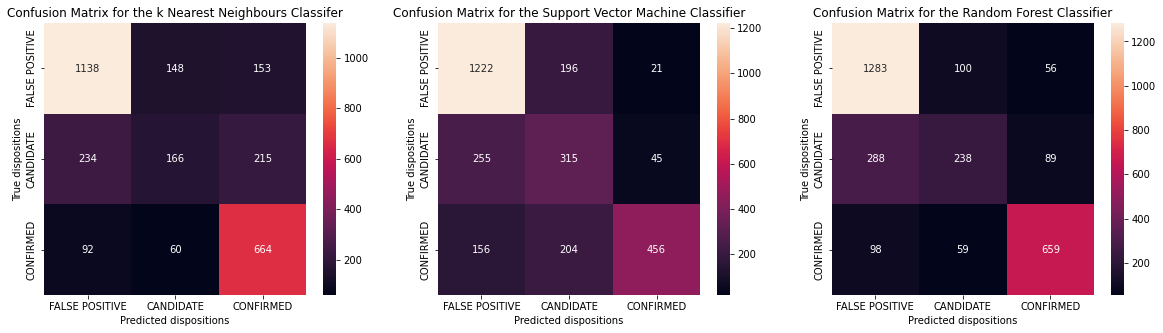

In [146]:
methods = (opt_knn, opt_svm, opt_rf)
accuracy = (accuracy_knn, accuracy_svm, accuracy_rf)
cm = [cm_knn, cm_svm, cm_rf]
method_names = ("k Nearest Neighbours Classifer", "Support Vector Machine Classifier", "Random Forest Classifier" )
print(cm[0][2, 0])
print("Erklärung - Confusion Matrix")
print("FP: FALSE POSITIVE")
print("CA.: CANDIDATE")
print("CO.: CONFIRMED")
print("vorh.: Vorhergesagte Klasse")
print("tats.: Tatsächliche Klasse")
print("")
fig = plt.figure(figsize=(20, 5))

for i in range(len(method_names)):
    ax = plt.subplot(1,3,i+1)
    sns.heatmap(cm[i], annot=True, fmt='g', ax=ax)
    ax.set_xlabel('Predicted dispositions')
    ax.set_ylabel('True dispositions')
    ax.set_title(f"Confusion Matrix for the {method_names[i]}")
    ax.xaxis.set_ticklabels(['FALSE POSITIVE', 'CANDIDATE', 'CONFIRMED'])
    ax.yaxis.set_ticklabels(['FALSE POSITIVE', 'CANDIDATE', 'CONFIRMED'])
    
plt.savefig(f'../data/figures/CM.png')
    #plot_confusion_matrix(methods[i], x_test, y_test, display_labels=(
     #   'FALSE POSITIVE', 'CANDIDATE', 'CONFIRMED'), title = f"Confusion matrox for the {method_names[i]}")
    # print(f"CONFUSION MATRIX FÜR {method_names[i]}-Modell mit")
    # print(f"Akkuranz = {accuracy[i]}")
    # print(f"          ||           ||           ||")
    # print(f"          || FP vorh.  || CA. vorh. || CO. vorh.")
    # print(f"          ||           ||           ||")
    # print(f"================================================")
    # print(f"          ||           ||           ||")
    # print(f"FP tats.  ||   {cm[i][0,0]}    ||     {cm[i][0,1]}   ||   {cm[i][0,2]}")
    # print(f"          ||           ||           ||")
    # print(f"================================================")
    # print(f"          ||           ||           ||")
    # print(f"CA. tats. ||    {cm[i][1,0]}    ||     {cm[i][1,1]}   ||   {cm[i][1,2]}")
    # print(f"          ||           ||           ||")
    # print(f"================================================")
    # print(f"          ||           ||           ||")
    # print(f"CO. tats. ||    {cm[i][2,0]}     ||     {cm[i][2,1]}    ||   {cm[i][2,2]}")
    # print(f"          ||           ||           ||")
    # print("")
    # print("")


In [349]:
def get_all_roc_coordinates(y_real, y_proba):

    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a treshold for the predicion of the class.\n",
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.\n",
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list


def calculate_tpr_fpr(y_real, y_pred): 

    '''
    Calculates the True Positive Rate (tpr) and the True Negative Rate (fpr) based on real and predicted observations
    
    Args:
        y_real: The list or series with the real classes
        y_pred: The list or series with the predicted classes
        
    Returns:
        tpr: The True Positive Rate of the classifier
        fpr: The False Positive Rate of the classifier
    '''
    # Calculates the confusion matrix and recover each element\n",
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr


def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
      '''
      Plots the ROC Curve by using the list of coordinates (tpr and fpr).
      
      Args:
          tpr: The list of TPRs representing each coordinate.
          fpr: The list of FPRs representing each coordinate.
          scatter: When True, the points used on the calculation will be plotted with the line (default = True).
      '''
      if ax == None:
          plt.figure(figsize = (5, 5))
          ax = plt.axes()
      
      if scatter:
          sns.scatterplot(x = fpr, y = tpr, ax = ax)
      sns.lineplot(x = fpr, y = tpr, ax = ax)
      sns.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
      plt.xlim(-0.05, 1.05)
      plt.ylim(-0.05, 1.05)
      plt.xlabel("False Positive Rate")
      plt.ylabel("True Positive Rate")
   

In [59]:
class_combos = []
class_list = list(koi_disposition_dict.keys())
for i in range(len(class_list)):

    for j in range(i+1, len(class_list)):
        class_combos.append((class_list[i], class_list[j]))
        class_combos.append((class_list[j], class_list[i]))

# Wandle Liste in Array um, passe die Dimensionen so an, dass eine Transponierung der ersten beiden
# Achsen dazu führt, dass erst drei unterschiedliche Dispositions-Paare im Array stehen und dann die
# umgekehrten Paare, passe dann wieder Dimensionen an und wandle das Array dann wieder in Liste um.
class_combos = (np.asarray(class_combos).reshape(3, 2, 2)).transpose(1, 0, 2).reshape(6,2).tolist()
#class_combos = np.reshape(class_combos, (6,2))
print(class_combos)


[['FALSE POSITIVE', 'CANDIDATE'], ['FALSE POSITIVE', 'CONFIRMED'], ['CANDIDATE', 'CONFIRMED'], ['CANDIDATE', 'FALSE POSITIVE'], ['CONFIRMED', 'FALSE POSITIVE'], ['CONFIRMED', 'CANDIDATE']]


ROC AUC für KNN-Methode
ROC AUC für KNN-Methode
ROC AUC von FALSE POSITIVE vs CANDIDATE: 0.7950
ROC AUC von FALSE POSITIVE vs CONFIRMED: 0.9293
ROC AUC von CANDIDATE vs CONFIRMED: 0.7294
ROC AUC von CANDIDATE vs FALSE POSITIVE: 0.6941
ROC AUC von CONFIRMED vs FALSE POSITIVE: 0.9269
ROC AUC von CONFIRMED vs CANDIDATE: 0.8060
Mittelwert von ROC AUC: 0.8134
---------------------------------------------------
ROC AUC für SVM-Methode
ROC AUC für SVM-Methode
ROC AUC von FALSE POSITIVE vs CANDIDATE: 0.8315
ROC AUC von FALSE POSITIVE vs CONFIRMED: 0.9380
ROC AUC von CANDIDATE vs CONFIRMED: 0.7136
ROC AUC von CANDIDATE vs FALSE POSITIVE: 0.8107
ROC AUC von CONFIRMED vs FALSE POSITIVE: 0.9416
ROC AUC von CONFIRMED vs CANDIDATE: 0.8793
Mittelwert von ROC AUC: 0.8525
---------------------------------------------------
ROC AUC für RF-Methode
ROC AUC für RF-Methode
ROC AUC von FALSE POSITIVE vs CANDIDATE: 0.8313
ROC AUC von FALSE POSITIVE vs CONFIRMED: 0.9684
ROC AUC von CANDIDATE vs CONFIRMED: 0.83

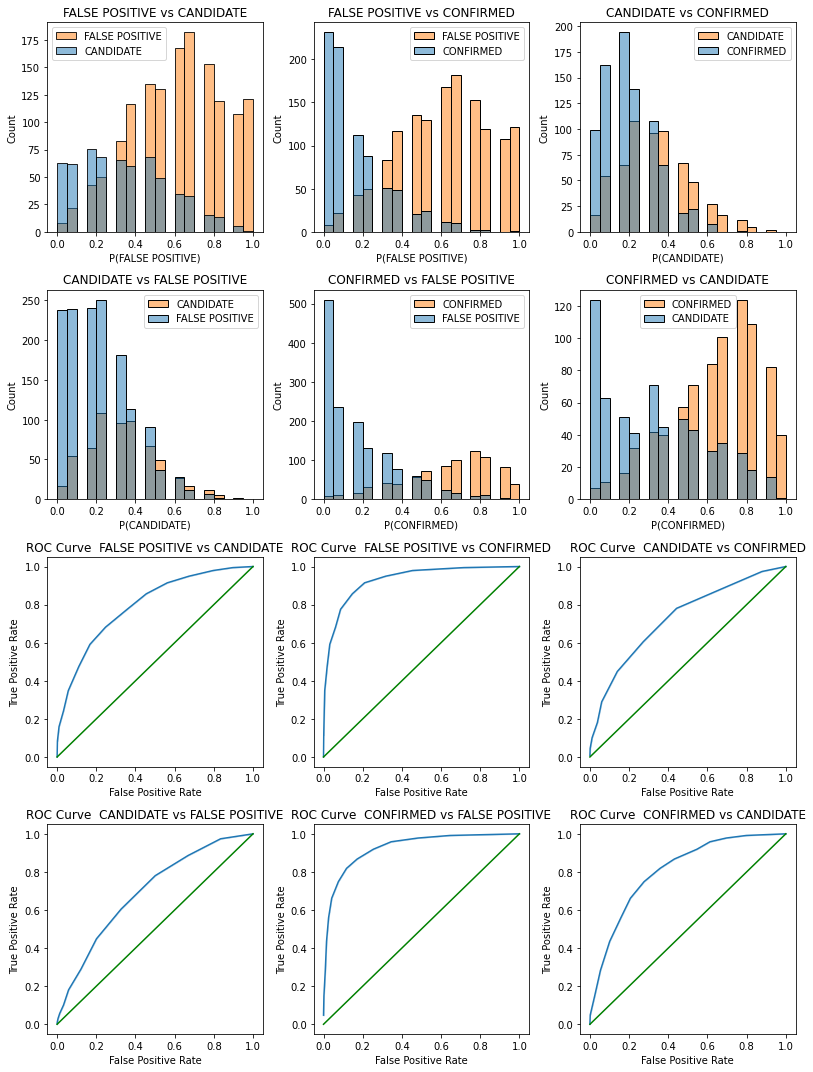

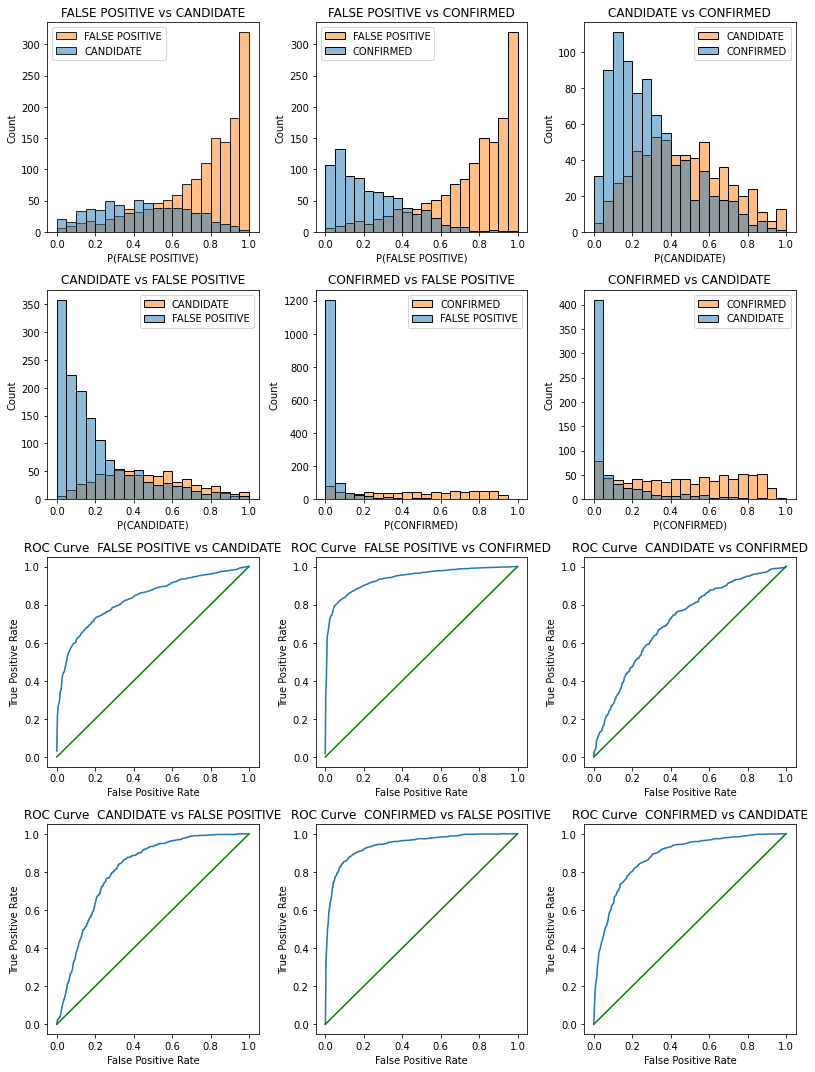

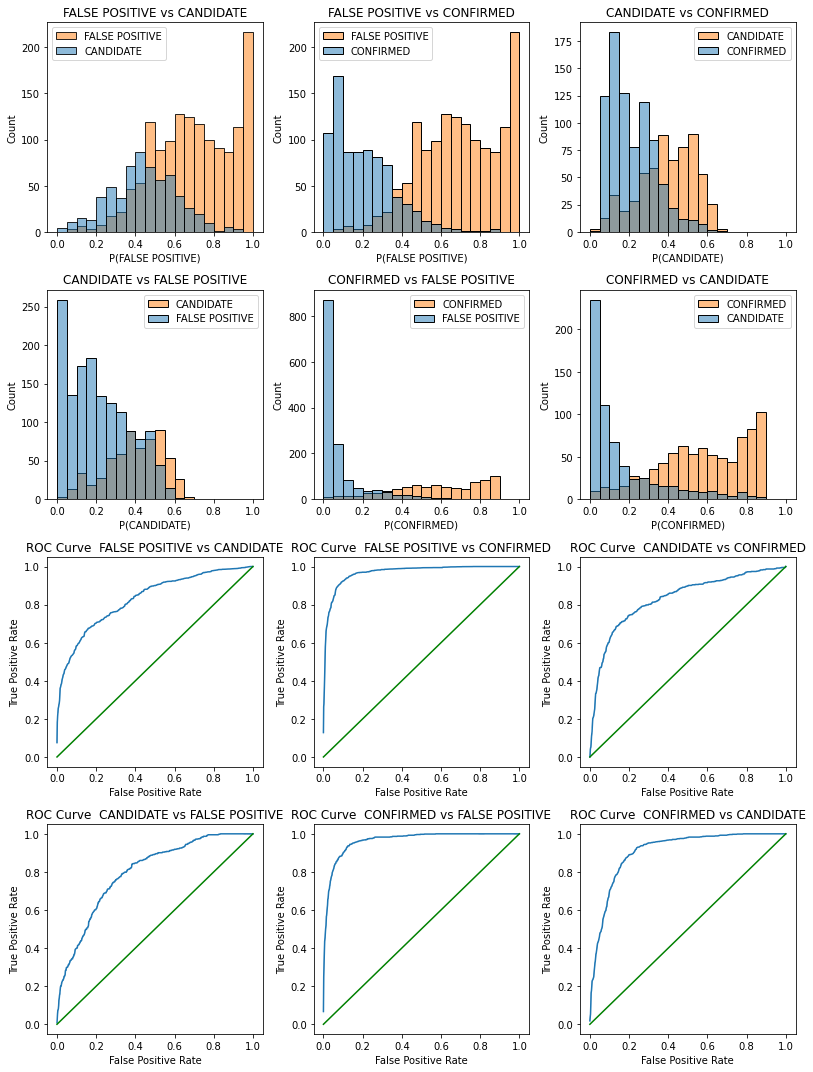

In [276]:
y_proba_all = np.array([y_proba_knn, y_proba_svm, y_proba_rf])
ml_method = ["KNN", "SVM", "RF"]
# Plots the Probability Distributions and the ROC Curves One vs One
#plt.figure(figsize=(20, 7))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovo = {}

for i in range(len(y_proba_all[:,0,0])):

    fig = plt.figure(figsize=(11.25, 15))
    print(f"ROC AUC für {ml_method[i]}-Methode")

    for j in range(len(class_combos)):
        
        # Gets the class
        combo = class_combos[j]
        c1 = combo[0]
        c2 = combo[1]
        c1_index = class_list.index(c1)
        c2_index = class_list.index(c2)
        title = f"{c1} vs {c2}"

        # Prepares an auxiliary dataframe to help with the plots
        df_aux = x_test.copy()
        df_aux['class'] = y_test
        #print(c1_index)
        #print(i)
        #print(y_proba_all[i, :, c1_index]
        df_aux['prob'] = y_proba_all[i, :, c1_index]  # Probability that instances ":" are of class c1

        # Slices only the subset with both classes
        df_aux = df_aux[(df_aux['class'] == c1_index) |
                        (df_aux['class'] == c2_index)]
        df_aux['class'] = [1 if y == c1_index else 0 for y in df_aux['class']]
        df_aux = df_aux.reset_index(drop=True)

        # Plots the probability distribution for the classes
        ax = plt.subplot(4, 3, j + 1)
        sns.histplot(x="prob", data=df_aux, hue='class', color='b', ax=ax, bins=bins)

        ax.set_title(title)
        ax.legend([f"{c1}", f"{c2}"])
        ax.set_xlabel(f"P({c1})")

        # Calculates the ROC Coordinates and plots the ROC Curves
        ax_bottom = plt.subplot(4, 3, j+7)
        tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])

        plot_roc_curve(tpr, fpr, scatter=False, ax=ax_bottom)
        ax_bottom.set_title(f"ROC Curve  {title}")
        #plt.savefig(f'../data/figures/hist_roc.png')
        fig.tight_layout()
        
        # Calculates the ROC AUC OvO
        roc_auc_ovo[title] = roc_auc_score(df_aux['class'], df_aux['prob'])
        
        #print(f"ROC AUC von {list(roc_auc_ovo)[j]}: {list(roc_auc_ovo.values())[j]:.4f}")

    plt.savefig(f'../data/figures/hist_roc_{ml_method[i]}.png')

    print(f"ROC AUC für {ml_method[i]}-Methode")
    for j in range(len(class_combos)):

        print(f"ROC AUC von {list(roc_auc_ovo)[j]}: {list(roc_auc_ovo.values())[j]:.4f}")
    print(f"Mittelwert von ROC AUC: {np.mean(list(roc_auc_ovo.values())):.4f}")
    print("---------------------------------------------------")

#plt.tight_layout()


In [76]:
# Displays the ROC AUC for each class
avg_roc_auc = 0
i = 0
for k in roc_auc_ovo:
    avg_roc_auc += roc_auc_ovo[k]
    i += 1
    print(f"{k} ROC AUC OvO: {roc_auc_ovo[k]:.4f}")
print(f"average ROC AUC OvO: {avg_roc_auc/i:.4f}")

FALSE POSITIVE vs CANDIDATE ROC AUC OvO: 0.8313
FALSE POSITIVE vs CONFIRMED ROC AUC OvO: 0.9684
CANDIDATE vs CONFIRMED ROC AUC OvO: 0.8319
CANDIDATE vs FALSE POSITIVE ROC AUC OvO: 0.7966
CONFIRMED vs FALSE POSITIVE ROC AUC OvO: 0.9643
CONFIRMED vs CANDIDATE ROC AUC OvO: 0.9076
average ROC AUC OvO: 0.8833


In [ ]:
x_train_logreg = x_train.drop(['koi_period', 'koi_period_err2', 'koi_time0bk_err2',
                               'koi_duration_err2', 'koi_tce_plnt_num', 'koi_steff', 'koi_steff_err2', 'koi_slogg_err1',
                               'koi_slogg_err2', 'dec', 'koi_kepmag'], axis=1)
x_test_logreg = x_test.drop(['koi_period', 'koi_period_err2', 'koi_time0bk_err2',
                              'koi_duration_err2', 'koi_tce_plnt_num', 'koi_steff', 'koi_steff_err2', 'koi_slogg_err1',
                              'koi_slogg_err2', 'dec', 'koi_kepmag'], axis=1)

model = LogisticRegression().fit(x_train_logreg, y_train)
model_predict = np.round(model.predict(x_test_logreg))
model_accuracy = accuracy_score(model_predict, y_test)
print(f"Genauigkeit von logregr: {model_accuracy:.04}")

Genauigkeit von logregr: 0.6014


In [357]:
# Triviale Hypothese

predict = np.zeros(len(y_test))

cm = confusion_matrix(y_test, predict)
#tn, fp, fn, tp = cm.ravel()

print("--------------------------------- \n TRIVIALE HYPOTHESE")
print(f"Accuracy: {accuracy_score(y_test, predict)}")
print(f"Ca. {(accuracy_score(y_test, predict)*100): .02f}% der Instanzen sind FALSE POSITIVE")
print(f"Confusion matrix: \n{cm}")
print(1234/(1234+496+661))
print(len(np.where(y_test == 0)[0])/len(y_test))


--------------------------------- 
 TRIVIALE HYPOTHESE
Accuracy: 0.5013937282229965
Ca.  50.14% der Instanzen sind FALSE POSITIVE
Confusion matrix: 
[[1439    0    0]
 [ 615    0    0]
 [ 816    0    0]]
0.5161020493517356
0.5013937282229965


In [ ]:
#Diagonale: Richtige vorhersagen. Oben links: Anzahl der richtigen Vorhersagen des kleinsten Wertes.
#                                 Unten rechts: Anzahl der richtigen Vorhersagen des größten Wertes.
# 1. Zeile: False Positive. Links: Anzahl der richtigen Vorhersagen. Mitte: Anzahl der fälschlicherweise als 1
# vorhergesagten. Rechts: Anzahl der fälschlicherweise als 2 vorhergesagten.
# 2. Zeile: Candidate. Links: Anzahl der Anzahl der fälschlicherweise als 0 vorhergesagten. Rechts: Anzahl der
# fälschlicherweise als 2 vorhergesagten.
# 3. Zeile: Confirmed. Links: Wie in 2. Zeile. Mitte: Wie in 1. Zeile.
y_true = [0, 1, 1, 2, 2, 2] 
y_pred = [0, 1, 2, 2, 2, 2]
confusion_matrix(y_true, y_pred)


array([[1, 0, 0],
       [0, 1, 1],
       [0, 0, 3]], dtype=int64)

In [ ]:
warnings.filterwarnings('ignore')


def rmse(y_pred, y):
    return np.sqrt(np.mean((y_pred-y)**2))


def train_evaluate_time(method):
    start_time = time.time()
    methods[method].fit(x_train, y_train)
    running_time = round(time.time() - start_time, 2)
    model_predict = methods[method].predict(x_test)
    model_rmse = rmse(model_predict, y_test)
    print(
        f"Genauigkeit von {method}: {model_rmse:.05}; running time: {running_time}")


methods = {"logregr": LogisticRegression(), "bag": BaggingClassifier(), "ada": AdaBoostClassifier(),  "tree": DecisionTreeClassifier(), "knn": KNeighborsClassifier(),
           "forest": RandomForestClassifier(), "svm": SVC()}

for method in methods:
    train_evaluate_time(method)


Genauigkeit von logregr: 1.208; running time: 0.33
Genauigkeit von bag: 1.1234; running time: 2.13
Genauigkeit von ada: 1.1075; running time: 1.3
Genauigkeit von tree: 1.152; running time: 0.3
Genauigkeit von knn: 1.1975; running time: 0.0
Genauigkeit von forest: 1.1775; running time: 3.79
Genauigkeit von svm: 1.2278; running time: 4.2


TypeError: list indices must be integers or slices, not str

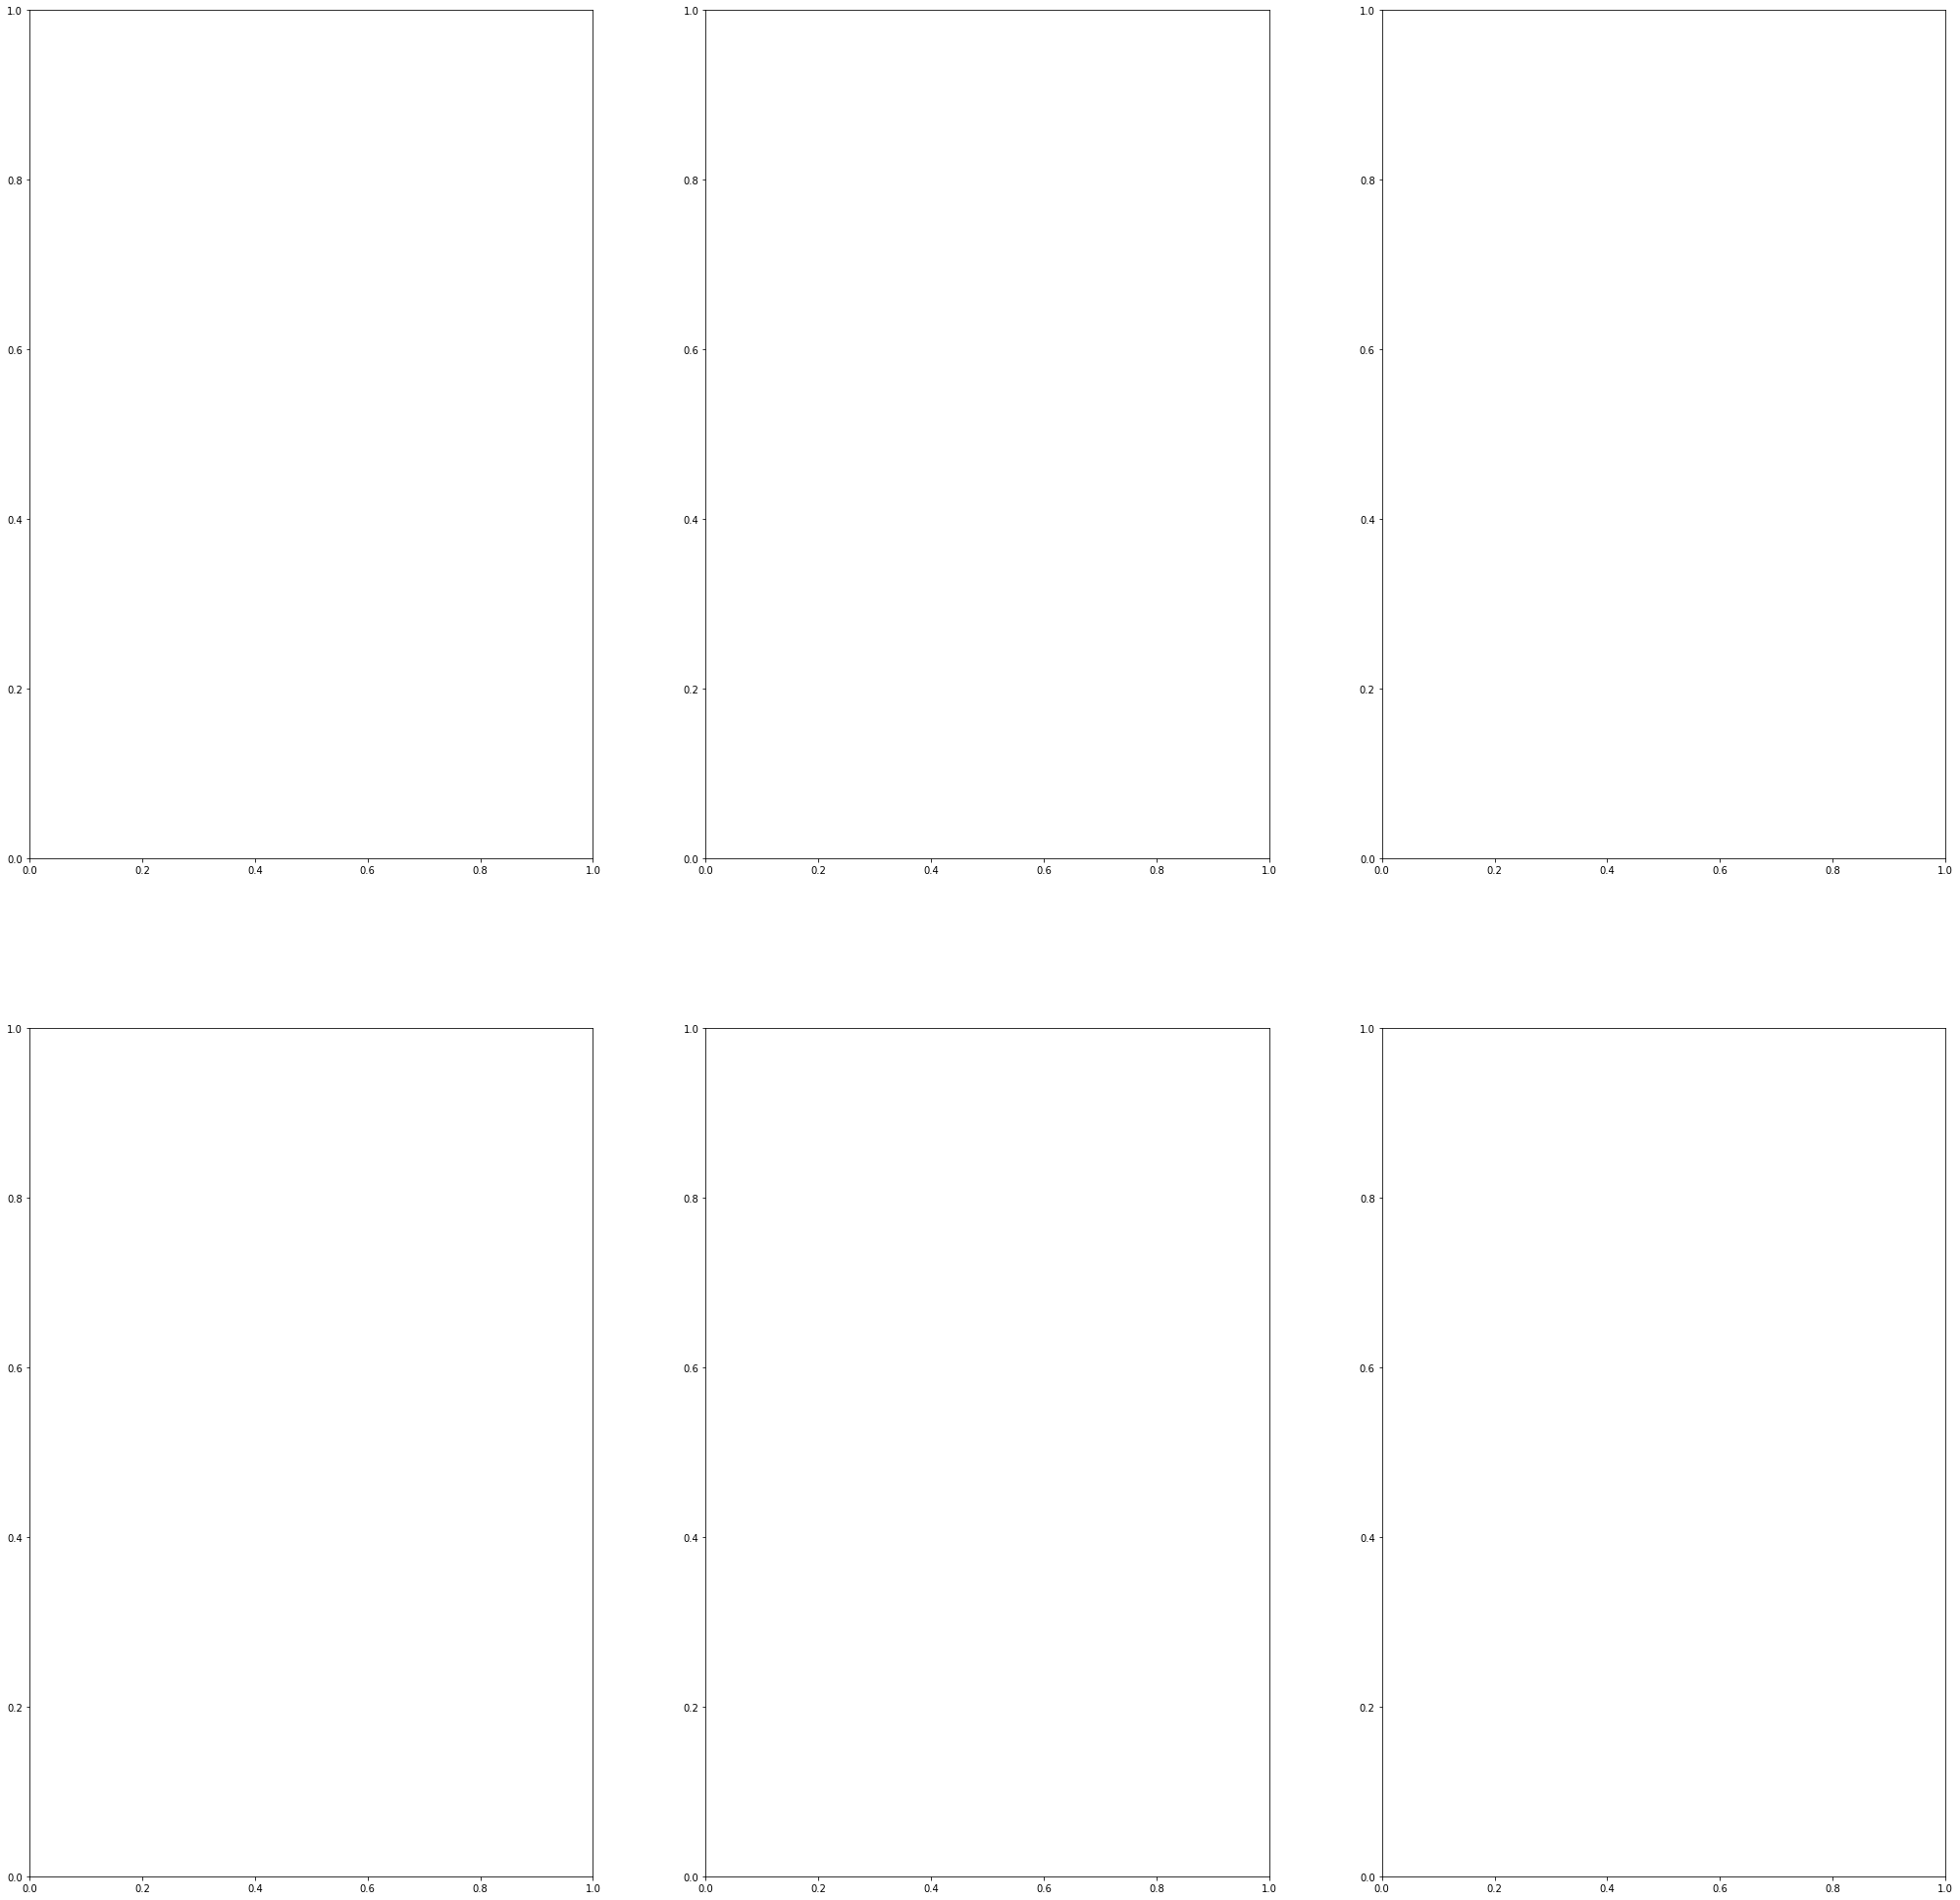

In [85]:
bag  = BaggingClassifier(DecisionTreeClassifier())
bag.fit(x_train, y_train)

bag_feature_importances = np.mean([tree.feature_importances_ for tree in bag.estimators_], axis=0)

def voting_feature_importance(voting_class, weights):
    """ Funktion, welche feature importance des Voting Classifier berechnet"""

    feature_importance = dict()
    for est in voting_class.estimators_:
        feature_importance[str(est)] = est.feature_importances_

    fe_scores = [0]*len(list(feature_importance.values())[0])
    for idx, imp_score in enumerate(feature_importance.values()):
        imp_score_with_weight = imp_score*weights[idx]
        feature_scores = list(np.add(fe_scores, list(imp_score_with_weight)))
    return feature_scores

def plot_one_method(ax, title, x):
    ax.set_title(title)
    ticks = np.arange(1, len(x) + 1)
    ax.bar(ticks, x)
    ax.set_xticks(ticks=ticks, labels=list(x_train.columns), rotation=90)


fig, ax = plt.subplots(2, 3, figsize=(35, 35))

plot_one_method(ax[0, 0], "Koeffizienten Logistische Regrssion",
                methods["logregr"].coef_[0])  # [0], weil das Array Dimensionen (1, <Spaltenanzahl>) hat, statt nur (<Spaltenanzahl>) 
plot_one_method(ax[0, 1], "Feature Importance beim Entscheidungsbaum",
                methods["tree"].feature_importances_)
plot_one_method(ax[0, 2], "Feature Importance beim Random Forest",
                methods["forest"].feature_importances_)
plot_one_method(ax[1, 0], "Feature Importance beim AdaBoost",
                methods["ada"].feature_importances_)
plot_one_method(ax[1, 1], "Feature Importance beim Bagging",
                bag_feature_importances)
#plot_one_method(ax[1, 2], "Feature Importance beim SVC", methods["svm"].feature_importances_)
plot_one_method(ax[1, 2], "Feature Importance beim Voting",
                voting_feature_importance(voting_class, weights=[1, 1, 2]))


In [217]:
methods = (opt_knn, opt_svm, opt_rf)
importances_test = []
for i in range(len(methods)):

    importance_test = permutation_importance(methods[i], x_test, y_test, scoring='accuracy')
    importances_test.append(importance.importances_mean)


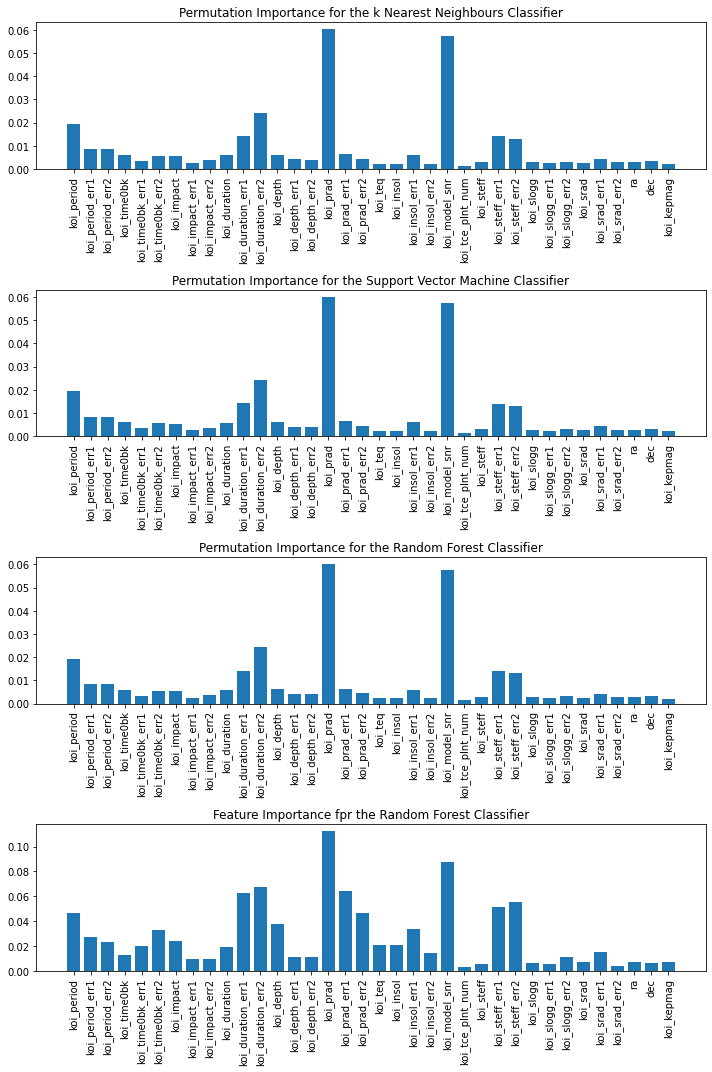

In [228]:
def plot_one_method(ax, title, x):
    ax.set_title(title)
    ticks = np.arange(1, len(x) + 1)
    ax.bar(ticks, x)
    ax.set_xticks(ticks=ticks, labels=list(x_train.columns), rotation=90)


importances = [importance_knn, importance_svm, importance_rf]

# fig = plt.figure(figsize=(20, 5))

#for i in range(len(method_names)):
#    ax = plt.subplot(1, 3, i+1)
#    sns.histplot(x=importances[i], data=x_test, hue='class',
#                 color='b', ax=ax, bins=bins)


#    plot_one_method(
#        ax[1], f"Feature Importance for the {method_names}", importances[i])
 #   plt.savefig(f'../data/figures/CM.png')
#plot_one_method(ax[3], "Feature Importance beim Random Forest Classifier",
#                opt_rf.feature_importances_)






fig, ax = plt.subplots(4, 1, figsize=(10, 15))
plot_one_method(
    ax[0], "Permutation Importance for the k Nearest Neighbours Classifier", importances_test[0])
plot_one_method(
    ax[1], "Permutation Importance for the Support Vector Machine Classifier", importances_test[1])

plot_one_method(
    ax[2], "Permutation Importance for the Random Forest Classifier", importances_test[2])

#plot_one_method(ax[1], "Feature Importance bei der Support Vector Machine Classifier", opt_svm.feature_importances_)
plot_one_method(ax[3], "Feature Importance fpr the Random Forest Classifier",
                opt_rf.feature_importances_)
plt.tight_layout()
plt.savefig(f'../data/figures/importances.png')
fig.tight_layout()


In [210]:
#feature_importance = scaled_data
#feature_importance.head()



results = permutation_importance(opt_knn, x_train, y_train, scoring='accuracy')
# get importance
importance_knn = results.importances_mean
# summarize feature importance
for i, v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i, v))
# plot feature importance


Feature: 0, Score: 0.01906
Feature: 1, Score: 0.00819
Feature: 2, Score: 0.00807
Feature: 3, Score: 0.00601
Feature: 4, Score: 0.00412
Feature: 5, Score: 0.00583
Feature: 6, Score: 0.00433
Feature: 7, Score: 0.00293
Feature: 8, Score: 0.00365
Feature: 9, Score: 0.00654
Feature: 10, Score: 0.01467
Feature: 11, Score: 0.02453
Feature: 12, Score: 0.00633
Feature: 13, Score: 0.00481
Feature: 14, Score: 0.00415
Feature: 15, Score: 0.05970
Feature: 16, Score: 0.00771
Feature: 17, Score: 0.00409
Feature: 18, Score: 0.00242
Feature: 19, Score: 0.00287
Feature: 20, Score: 0.00630
Feature: 21, Score: 0.00140
Feature: 22, Score: 0.05707
Feature: 23, Score: 0.00134
Feature: 24, Score: 0.00263
Feature: 25, Score: 0.01455
Feature: 26, Score: 0.01264
Feature: 27, Score: 0.00272
Feature: 28, Score: 0.00218
Feature: 29, Score: 0.00388
Feature: 30, Score: 0.00206
Feature: 31, Score: 0.00359
Feature: 32, Score: 0.00239
Feature: 33, Score: 0.00293
Feature: 34, Score: 0.00451
Feature: 35, Score: 0.00254


In [208]:
#feature_importance = scaled_data
#feature_importance.head()



results = permutation_importance(opt_svm, x_train, y_train, scoring='accuracy')
# get importance
importance_svm = results.importances_mean
# summarize feature importance
for i, v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i, v))
# plot feature importance


Feature: 0, Score: 0.01906
Feature: 1, Score: 0.00819
Feature: 2, Score: 0.00807
Feature: 3, Score: 0.00601
Feature: 4, Score: 0.00412
Feature: 5, Score: 0.00583
Feature: 6, Score: 0.00433
Feature: 7, Score: 0.00293
Feature: 8, Score: 0.00365
Feature: 9, Score: 0.00654
Feature: 10, Score: 0.01467
Feature: 11, Score: 0.02453
Feature: 12, Score: 0.00633
Feature: 13, Score: 0.00481
Feature: 14, Score: 0.00415
Feature: 15, Score: 0.05970
Feature: 16, Score: 0.00771
Feature: 17, Score: 0.00409
Feature: 18, Score: 0.00242
Feature: 19, Score: 0.00287
Feature: 20, Score: 0.00630
Feature: 21, Score: 0.00140
Feature: 22, Score: 0.05707
Feature: 23, Score: 0.00134
Feature: 24, Score: 0.00263
Feature: 25, Score: 0.01455
Feature: 26, Score: 0.01264
Feature: 27, Score: 0.00272
Feature: 28, Score: 0.00218
Feature: 29, Score: 0.00388
Feature: 30, Score: 0.00206
Feature: 31, Score: 0.00359
Feature: 32, Score: 0.00239
Feature: 33, Score: 0.00293
Feature: 34, Score: 0.00451
Feature: 35, Score: 0.00254


In [303]:
#feature_importance = scaled_data
#feature_importance.head()

perm_imp_knn = permutation_importance(opt_knn, x_test, y_test, scoring='accuracy')
importance_knn = perm_imp_knn.importances_mean

perm_imp_svm = permutation_importance(opt_svm, x_test, y_test, scoring='accuracy')
importance_svm = perm_imp_svm.importances_mean

perm_imp_rf = permutation_importance(opt_rf, x_test, y_test, scoring='accuracy')
importance_rf = perm_imp_rf.importances_mean
# summarize feature importance
#for i, v in enumerate(importance):
#	print('Feature: %0d, Score: %.5f' % (i, v))
# plot feature importance


# def plot_one_method(ax, title, x):
#     ax.set_title(title)
#     ticks = np.arange(1, len(x) + 1)
#     ax.bar(ticks, x)
#     ax.set_xticks(ticks=ticks, labels=list(x_train.columns), rotation=90)


# fig, ax = plt.subplots(4, 1, figsize=(15, 20))
# plot_one_method(
#     ax[0], "Feature Importance beim k Nearest Neighbours Classifier", importance_knn)
# plot_one_method(
#     ax[1], "Feature Importance beim k Nearest Neighbours Classifier", importance_svm)

# plot_one_method(
#     ax[2], "Feature Importance beim k Nearest Neighbours Classifier", importance_rf)

# #plot_one_method(ax[1], "Feature Importance bei der Support Vector Machine Classifier", opt_svm.feature_importances_)
# plot_one_method(
# 	ax[3], "Feature Importance beim Random Forest Classifier", opt_rf.feature_importances_)
# fig.tight_layout()


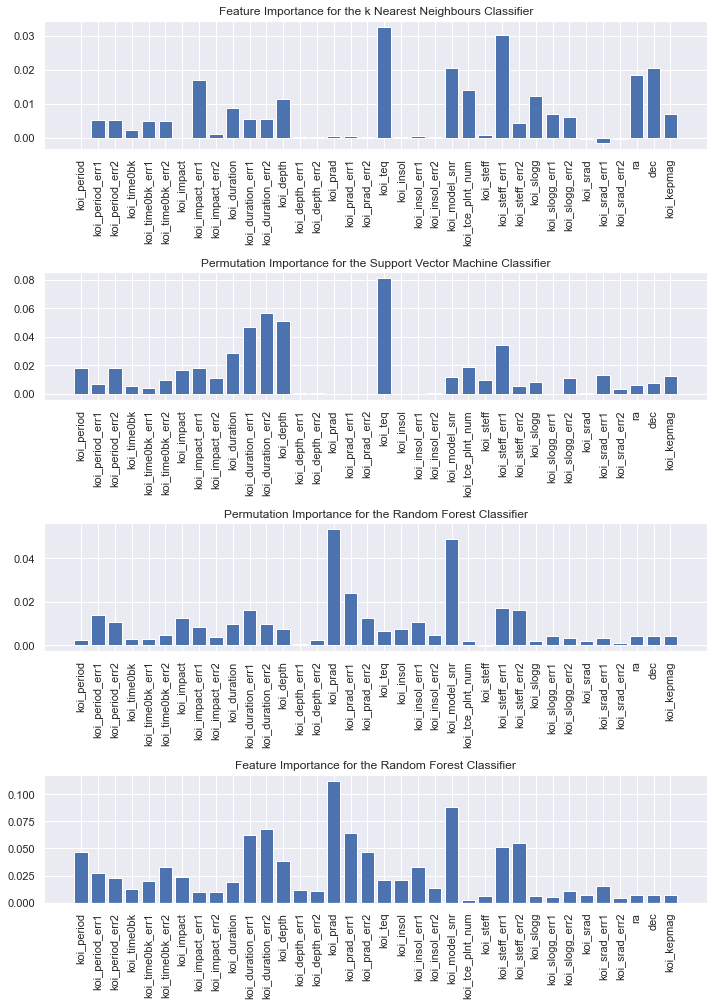

In [304]:
def plot_one_method(ax, title, x):
    ax.set_title(title)
    ticks = np.arange(1, len(x) + 1)
    ax.bar(ticks, x)
    ax.set_xticks(ticks=ticks, labels=list(x_train.columns), rotation=90)


fig, ax = plt.subplots(4, 1, figsize=(10, 14.14))
plot_one_method(
    ax[0], "Feature Importance for the k Nearest Neighbours Classifier", importance_knn)
plot_one_method(
    ax[1], "Permutation Importance for the Support Vector Machine Classifier", importance_svm)

plot_one_method(
    ax[2], "Permutation Importance for the Random Forest Classifier", importance_rf)

#plot_one_method(ax[1], "Feature Importance bei der Support Vector Machine Classifier", opt_svm.feature_importances_)
plot_one_method(ax[3], "Feature Importance for the Random Forest Classifier", opt_rf.feature_importances_)
fig.tight_layout()
plt.savefig(f'../data/figures/importances.png')



In [ ]:
def f_importances(coef, names):
    imp = coef
    imp, names = zip(*sorted(zip(imp, names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()


features_names = ['input1', 'input2']
svm_class = SVC
svm_class.fit(x_train, y_train)
f_importances(svm_class.coef_, features_names)


TypeError: BaseLibSVM.fit() missing 1 required positional argument: 'y'

In [57]:
print("Base Rate: Akkuranz der Annahme, dass alle Ziele den häufigsten Wert, FALSE POSITIVE, annehmen")

print("TESTDATEN")
print(f"Anzahl der KOI: {len(y_test)}")
print(f"Anzahl falsch positiver KOI: {len(np.where(y_test == 0)[0])}")
print(f"Anzahl der Kandidaten-KOI: {len(np.where(y_test == 1)[0])}")
print(f"Anzahl der bestätigten KOI: {len(np.where(y_test == 2)[0])}")
print(f"Base Rate: {len(np.where(y_test == 0)[0])/len(y_test)}")

print("GESAMTER DATENSATZ")
print(f"Anzahl der KOI: {len(data['koi_disposition'])}")
print(
    f"Anzahl falsch positiver KOI: {len(data.loc[data['koi_disposition'] == 0])}")
print(
    f"Anzahl der Kandidaten-KOI: {len(data.loc[data['koi_disposition'] == 1])}")
print(
    f"Anzahl der bestätigten KOI: {len(data.loc[data['koi_disposition'] == 2])}")
print(
    f"Base Rate: {len(data.loc[data['koi_disposition'] == 0])/len(data['koi_disposition'])}")


Base Rate: Akkuranz der Annahme, dass alle Ziele den häufigsten Wert, FALSE POSITIVE, annehmen
TESTDATEN
Anzahl der KOI: 2870
Anzahl falsch positiver KOI: 1439
Anzahl der Kandidaten-KOI: 615
Anzahl der bestätigten KOI: 816
Base Rate: 0.5013937282229965
GESAMTER DATENSATZ
Anzahl der KOI: 9564
Anzahl falsch positiver KOI: 0
Anzahl der Kandidaten-KOI: 0
Anzahl der bestätigten KOI: 0
Base Rate: 0.0


In [54]:
data = pd.read_csv('../data/cumulative.csv')
#data = pd.read_csv('../data/cumulative_2022.04.28_05.30.33.csv', header=53)
print(f"Anzahl der KOI: {len(data['koi_disposition'])}")
print(f"Anzahl falsch positiver KOI: {len(data.loc[data['koi_disposition'] == 'FALSE POSITIVE'])}")
print(
    f"Anzahl der Kandidaten-KOI: {len(data.loc[data['koi_disposition'] == 'CANDIDATE'])}")
print(
    f"Anzahl der bestätigten KOI: {len(data.loc[data['koi_disposition'] == 'CONFIRMED'])}")
print(
    f"Basis-Rate: {len(data.loc[data['koi_disposition'] ==  'FALSE POSITIVE'])/len(data['koi_disposition'])}")


Anzahl der KOI: 9564
Anzahl falsch positiver KOI: 5023
Anzahl der Kandidaten-KOI: 2248
Anzahl der bestätigten KOI: 2293
Basis-Rate: 0.5251986616478461


In [245]:
explainer_knn = shap.Explainer(fit_knn)#, x_train)
shap_values_knn = explainer_knn(x_train)  # .shap_values(x_train)


Exception: The passed model is not callable and cannot be analyzed directly with the given masker! Model: KNeighborsClassifier(n_neighbors=13, p=1)

In [241]:
kernel_explainer_knn = shap.KernelExplainer(opt_knn.predict, x_train)
kernel_shap_values_knn = kernel_explainer_knn.shap_values(x_train)


Using 6694 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/6694 [00:10<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
explainer_svm = shap.Explainer(opt_svm.predict, x_train)
shap_values_svm = explainer_svm.shap_values(x_train)


In [ ]:
kernel_explainer_svm = shap.KernelExplainer(opt_svm.predict, x_train)
kernel_shap_values_svm = kernel_explainer_svm.shap_values(x_train)


In [254]:

explainer_rf = shap.Explainer(fit_rf)# #(opt_rf.predict, x_train)
shap_values_rf = explainer_rf.shap_values(x_train)



In [271]:
# Using 6694 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
kernel_explainer_rf = shap.KernelExplainer(opt_rf.predict, x_train)
kernel_shap_values_rf = kernel_explainer_rf.shap_values(shap.sample(x_train, 42))
#kernel_shap_values_rf = kernel_explainer_rf.shap_values(shap.kmeans(x_train, 42))
#kernel_shap_values_rf = kernel_explainer_rf.shap_values(shap.kmeans(x_train, 42), nsamples = 42)


Using 6694 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/42 [00:10<?, ?it/s]


MemoryError: Unable to allocate 3.81 GiB for an array with shape (2120, 240984) and data type float64

In [257]:
kernel_explainer_rf = shap.GPUTreeExplainer(opt_rf.predict, x_train)
kernel_shap_values_rf = kernel_explainer_rf.shap_values(x_train)


Exception: Model type not yet supported by TreeExplainer: <class 'method'>

  0%|          | 0/6694 [02:43<?, ?it/s]


KeyboardInterrupt: 

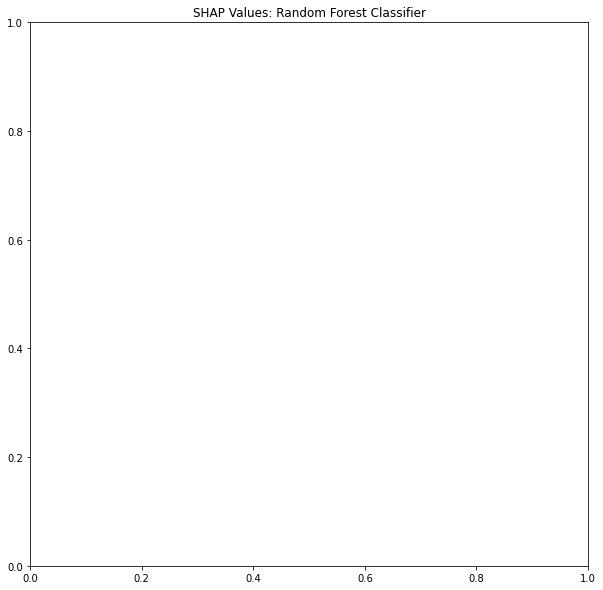

In [258]:
plt.figure(figsize=(10, 10))
plt.title(f"SHAP Values: {method_names[2]}")
shap.plots.beeswarm(kernel_explainer_rf.shap_values(x_train))
#shap.summary_plot(shap_values_rf, x_train)
plt.show()
